In this notebook we determine the magnitude and color based selection of the spectroscopic calibration sample using the `fuji` dataset. We also estimate the $p(z)$ of the ELGs.

Author: Tanveer Karim
Last Updated: November 8 2022

**Note**: This notebook should be run with DESI master kernel. 

In [1]:
import os
import numpy as np

from astropy.io import fits
from astropy.table import Table
import healpy as hp 

import sys
sys.path.insert(1, '/global/homes/t/tanveerk/lselgsXplanck/src/')
import utilsAstro

import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("seaborn-paper")

%matplotlib inline

## Import data

### DESI SV3 `fuji` data

In [2]:
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra

#from desitarget.targetmask import desi_mask, bgs_mask, scnd_mask    # For the main survey
#from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, scnd_mask    # For SV1
#from desitarget.sv2.sv2_targetmask import desi_mask, bgs_mask, scnd_mask    # For SV2
from desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, scnd_mask    # For SV3a

In [3]:
# Release directory path

specprod = 'fuji'
survey_dir = f'/global/cfs/cdirs/desi/spectro/redux/{specprod}'

Read in redshift catalogue

In [4]:
survey = 'sv3'
faprgrm = 'dark' 

zcat = Table.read(f'{survey_dir}/zcatalog/zpix-{survey}-{faprgrm}.fits', hdu="ZCATALOG")

In [5]:
# Targeting information about the DESI targetting is stored in the desi_target columns - 
desi_target = zcat['SV3_DESI_TARGET']

# Masks for different targets
elg_tgtmask = desi_mask['ELG']

### Convert magnitudes and calculate colours for histogram analysis
We will use the 2D histogram on the $g-r$ vs $r-z$ space to decide whether certain cuts cluster in a particular fashion. 

#### Milky Way Transmission for the ELGs
We need to correct the magnitudes for Milky Way dust extinction

In [6]:
from desiutil.dust import mwdust_transmission

In [7]:
len(zcat[(desi_target & elg_tgtmask != 0)])

397288

### Condition for selecting by PHOTSYS

In [8]:
#bands = np.array(['G', 'R', 'Z', 'W1', 'W2'])
bands = np.array(['G', 'R', 'Z'])
is_good_photsys = ~zcat['PHOTSYS'].mask # some photsys are masked
zcat_good_photsys = zcat[is_good_photsys & ((desi_target & elg_tgtmask != 0))]

In [9]:
#mw_transmission_dict = {}

for band in bands:
    #mw_transmission_dict[band] = np.zeros(len(zcat_elg))
    zcat_good_photsys['MW_TRANSMISSION_' + band] = np.zeros(len(zcat_good_photsys))
    for i in range(len(zcat_good_photsys)):
        zcat_good_photsys['MW_TRANSMISSION_' + band][i] = mwdust_transmission(zcat_good_photsys['EBV'][i], band, 
                                                                              zcat_good_photsys['PHOTSYS'][i])

#### Convert nanomaggies to proper magnitude unit

In [10]:
def nmgy2mag(nmgy, ivar=None):
    """
    Name:
        nmgy2mag
    Purpose:
        Convert SDSS nanomaggies to a log10 magnitude.  Also convert
        the inverse variance to mag err if sent.  The basic formulat
        is 
            mag = 22.5-2.5*log_{10}(nanomaggies)
    Calling Sequence:
        mag = nmgy2mag(nmgy)
        mag,err = nmgy2mag(nmgy, ivar=ivar)
    Inputs:
        nmgy: SDSS nanomaggies.  The return value will have the same
            shape as this array.
    Keywords:
        ivar: The inverse variance.  Must have the same shape as nmgy.
            If ivar is sent, then a tuple (mag,err) is returned.
    Outputs:
        The magnitudes.  If ivar= is sent, then a tuple (mag,err)
        is returned.
    Notes:
        The nano-maggie values are clipped to be between 
            [0.001,1.e11]
        which corresponds to a mag range of 30 to -5
    """
    nmgy = np.array(nmgy, ndmin=1, copy=False)

    nmgy_clip = np.clip(nmgy,1e-5,1e11)

    mag = nmgy_clip.copy()
    mag[:] = 22.5-2.5*np.log10(nmgy_clip)

    if ivar is not None:

        ivar = np.array(ivar, ndmin=1, copy=False)
        if ivar.shape != nmgy.shape:
            raise ValueError("ivar must be same shape as input nmgy array")

        err = mag.copy()
        err[:] = np.inf

        w=np.where( ivar > 0 )

        if w[0].size > 0:
            err[w] = np.sqrt(1.0/ivar[w])

            a = 2.5/np.log(10)
            err[w] *= a/nmgy_clip[w]

        return mag, err
    else:
        return mag

In [11]:
for band in bands:
    zcat_good_photsys['MAG_' + band] = nmgy2mag(zcat_good_photsys['FLUX_' + band]/zcat_good_photsys['MW_TRANSMISSION_' + band])

zcat_good_photsys['gfib'] = nmgy2mag(zcat_good_photsys['FIBERFLUX_G']/zcat_good_photsys['MW_TRANSMISSION_G'])
zcat_good_photsys['rfib'] = nmgy2mag(zcat_good_photsys['FIBERFLUX_R']/zcat_good_photsys['MW_TRANSMISSION_R'])
zcat_good_photsys['zfib'] = nmgy2mag(zcat_good_photsys['FIBERFLUX_Z']/zcat_good_photsys['MW_TRANSMISSION_Z'])
zcat_good_photsys['g-r'] = zcat_good_photsys['MAG_G'] - zcat_good_photsys['MAG_R']
zcat_good_photsys['r-z'] = zcat_good_photsys['MAG_R'] - zcat_good_photsys['MAG_Z']

## Does `COADD_FIBERSTATUS` cluster?

In [12]:
range2d = np.array([[0.10, 1.75], [-0.5, .6]])
vmin = 0
vmax = 250
nbins = 100

### Condition for selecting by COADD_FIBERSTATUS

In [13]:
is_coadd_good_photsys = (zcat_good_photsys['COADD_FIBERSTATUS'] == 0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


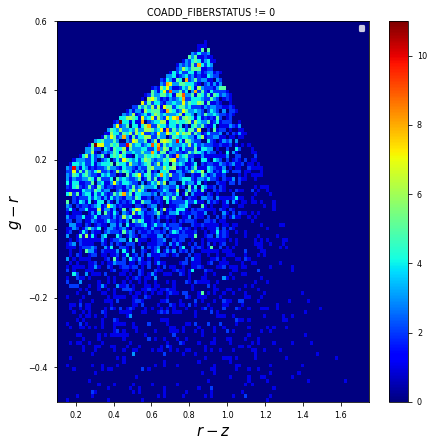

In [14]:
plt.figure(figsize = (7,7))
plt.hist2d(zcat_good_photsys['r-z'][~is_coadd_good_photsys], zcat_good_photsys['g-r'][~is_coadd_good_photsys], 
            bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin);
plt.xlabel(r"$r-z$", fontsize = 15)
plt.ylabel(r"$g-r$", fontsize = 15)
plt.title("COADD_FIBERSTATUS != 0 ")
plt.legend(loc = 'best')
plt.colorbar()

Observation: `COADD_FIBERSTATUS != 0` does not have any particular trend. So we can safely apply this cut. 

### Condition for selecting by ELG bitmask

Next, we apply bitmask values to select ELG targets 

In [15]:
is_elg = (zcat_good_photsys['SV3_DESI_TARGET'] & elg_tgtmask != 0) & is_coadd_good_photsys

zcat_elg = zcat_good_photsys[is_elg]

# Number of sources
n_elg = len(zcat_elg)

print(f'Number of ELGs: {n_elg}')

Number of ELGs: 390901


## When grouped by `MORPHTYPE` what is the redshift distribution and what is the distribution of `SPECTYPE`?

Relevant columns are: `SHAPE_R`, `SHAPE_E1`, `SHAPE_E2`, `SERSIC`

In [16]:
for morph in np.unique(zcat_elg['MORPHTYPE']):
    print(f"% of {morph} is {(zcat_elg['MORPHTYPE'] == morph).sum()/len(zcat_elg['MORPHTYPE']) * 100}")

% of DEV is 2.216929606217431
% of EXP is 7.143240871729671
% of PSF is 37.37288981097516
% of REX is 53.15028613382928
% of SER is 0.11665357724845932


#### Distribution of `SPECTYPE`

In [17]:
for morph in np.unique(zcat_elg['MORPHTYPE']):
    flag = (zcat_elg['MORPHTYPE'] == morph)
    zcat_elg[flag]['SPECTYPE']
    print(f"Morph type: {morph}")
    print("-------")
    for spec in np.unique(zcat_elg[flag]['SPECTYPE']):
        print(f"% of {spec} is {(zcat_elg[flag]['SPECTYPE'] == spec).sum()/len(zcat_elg[flag]['SPECTYPE']) * 100}")
    print("-----")

Morph type: DEV
-------
% of GALAXY is 94.38033694899607
% of QSO is 5.285021924763443
% of STAR is 0.33464112624048004
-----
Morph type: EXP
-------
% of GALAXY is 99.24793181248434
% of QSO is 0.5622605020950471
% of STAR is 0.189807685420621
-----
Morph type: PSF
-------
% of GALAXY is 88.32440054486587
% of QSO is 11.275848614904408
% of STAR is 0.39975084022971985
-----
Morph type: REX
-------
% of GALAXY is 98.8698770245229
% of QSO is 1.081510360262797
% of STAR is 0.04861261521430462
-----
Morph type: SER
-------
% of GALAXY is 87.5
% of QSO is 10.964912280701753
% of STAR is 1.5350877192982455
-----


### Plot: Distribution of redshift

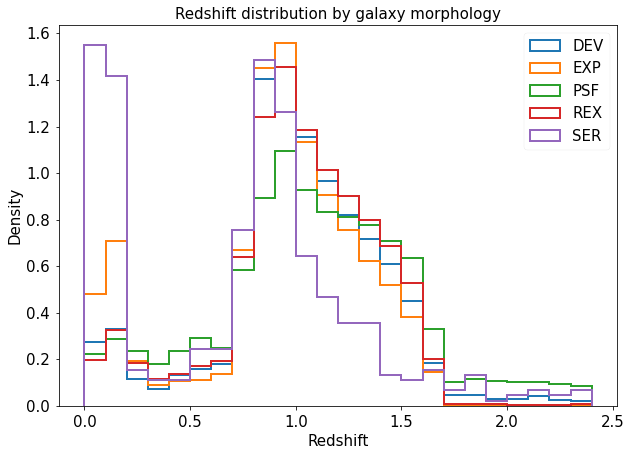

In [18]:
plt.figure(figsize = (10, 7))

for morph in np.unique(zcat_elg['MORPHTYPE']):
    flag = (zcat_elg['MORPHTYPE'] == morph)
    plt.hist(zcat_elg[flag]['Z'], bins = np.arange(0, 2.5, 0.1), histtype= 'step', 
             label = morph, lw = 2, density = True)

plt.title("Redshift distribution by galaxy morphology", fontsize = 15)
plt.ylabel("Density", fontsize = 15)
plt.xlabel("Redshift", fontsize = 15)
plt.legend(loc = 'best', fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("../figures/sersic.pdf", dpi = 400, bbox_inches = 'tight')

Observation: We see that Sersic profile targets have a large QSO contamination problem. We clip these because they form only $0.12\%$ of the sample. 

### Condition for removing Sersic galaxies as they are low-z 

In [18]:
is_not_sersic = (zcat_elg['MORPHTYPE'] != 'SER')
zcat_elg = zcat_elg[is_not_sersic]

### Cuts on `SHAPE_R`

We look at whether we can apply cuts based on half-light radii. 

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


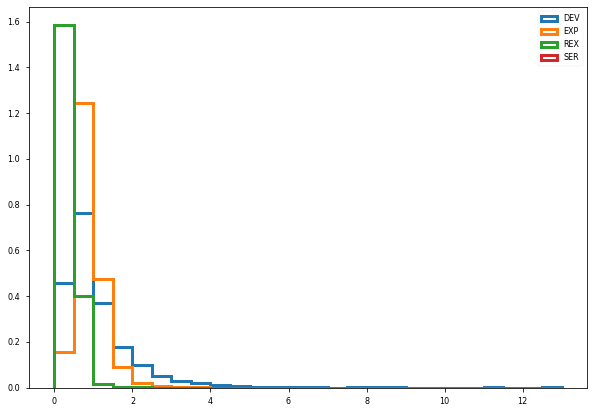

In [20]:
plt.figure(figsize=(10, 7))

for morph in ['DEV', 'EXP', 'REX', 'SER']:
    flag = (zcat_elg['MORPHTYPE'] == morph)
    
    plt.hist(zcat_elg[flag]['SHAPE_R'], bins = np.arange(0, 13.5, .5), label = morph, 
             alpha = 1, lw = 3, histtype = 'step', density = True)

plt.legend(loc = 'best')
plt.show()

Mean of DEV in SHAPE_R: 1.116983413696289
Mean of EXP in SHAPE_R: 0.9024718403816223
Mean of REX in SHAPE_R: 0.4026206433773041


/tmp/ipykernel_56917/1326335268.py:5: RuntimeWarning: Mean of empty slice.
  print(f"Mean of {morph} in SHAPE_R: {zcat_elg[flag]['SHAPE_R'].mean()}")
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Mean of SER in SHAPE_R: nan


/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


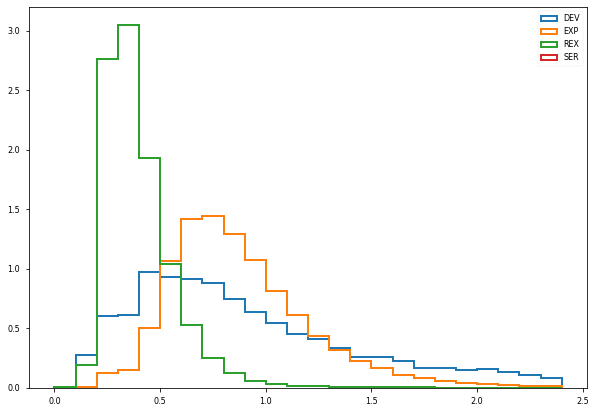

In [19]:
plt.figure(figsize = (10, 7))

for morph in ['DEV', 'EXP', 'REX', 'SER']:
    flag = (zcat_elg['MORPHTYPE'] == morph)
    print(f"Mean of {morph} in SHAPE_R: {zcat_elg[flag]['SHAPE_R'].mean()}")
    plt.hist(zcat_elg[flag]['SHAPE_R'], bins = np.arange(0, 2.5, 0.1), histtype= 'step', 
             label = morph, lw = 2, density = True)
    
plt.legend(loc = 'best')

In [20]:
np.sum(zcat_elg['SHAPE_R'] > 1.5)/len(zcat_elg)

0.01010129467658697

Observation: Only $1\%$ of the samples have `SHAPE_R` > 1.5. We apply this cut to reduce shot noise induced by the samples with a larger `SHAPE_R` value. 

## Does `FOII_SNR` vs `DELTACHI2` cut cluster?

In the ELG target selection paper (Raichoor et al. 2022) it is shown that the spectroscopic redshift reliability rate is a function of `FOII_SNR` and `DELTACHI2`. We apply use this spectroscopic cut to define which targets get the label $2$, i.e., bad. 

### Anand's [OII] flux dataset

We use this dataset to apply the FOII_SNR vs DELTACHI2 cut

In [21]:
# augment [OII] flux for the training galaxies

#relevant emline.fits files generated by Anand Raichoor
from astropy.table import Table, vstack
from glob import glob
fns=sorted(glob("/global/cfs/cdirs/desi/spectro/redux/fuji/healpix/sv3/dark/*/*/emline*fits"))

# those all have unique targetids, and no overlap
e = vstack([Table.read(fn,"EMLINEFIT") for fn in fns], metadata_conflicts="silent")

In [22]:
# check if TARGETID are unique 

def duplicate_test(A):
    return np.any(np.diff(np.sort(A, axis=0), axis=0) == 0)

print(duplicate_test(zcat_elg['TARGETID']))
print(duplicate_test(e['TARGETID']))

False
False


In [23]:
# then match by TARGETID

from desitarget.geomask import match, match_to

is_in_elg_cat = match_to(e['TARGETID'], zcat_elg['TARGETID'])
e_elg = e[is_in_elg_cat]

In [24]:
#verify that the ordering of the sliced Table matches zcat_elg

(zcat_elg['TARGETID']== e_elg['TARGETID']).sum() - len(zcat_elg)

0

In [25]:
#augment zcat_elg table
zcat_elg['OII_FLUX'] = e_elg['OII_FLUX']
zcat_elg['OII_FLUX_IVAR'] = e_elg['OII_FLUX_IVAR']
zcat_elg['OII_SNR'] = zcat_elg['OII_FLUX'] * np.sqrt(zcat_elg['OII_FLUX_IVAR'])
zcat_elg['log10_OII_SNR'] = np.log10(zcat_elg['OII_SNR'])
zcat_elg['log10_DELTACHI2'] = np.log10(zcat_elg['DELTACHI2'])

/tmp/ipykernel_56917/3030149548.py:5: RuntimeWarning: invalid value encountered in log10
  zcat_elg['log10_OII_SNR'] = np.log10(zcat_elg['OII_SNR'])


We then check that the rows are unique in the dataset. 

In [26]:
len(zcat_elg['TARGETID']) == len(np.unique(zcat_elg['TARGETID']))

True

In [27]:
len(zcat['TARGETID']) == len(np.unique(zcat['TARGETID']))

True

If the `TARGETID` were not unique, then the numbers would not be the same as the length of the second array would be smaller. 

## astropy casting issue
Note this interesting situation where converting masked values into numpy casts it as 1. We need to get rid of rows with masked values because these galaxies cannot be used for flux based selection. 

We do not explicitly get rid of them from the training sample because this cut is based on spectroscopic properties. Rather we define the masked values as "bad" galaxies and assign them the label $2$ later on. 

In [29]:
print(zcat_elg['log10_OII_SNR'][(zcat_elg['OII_FLUX'].mask)])
print(np.array(zcat_elg['log10_OII_SNR'][(zcat_elg['OII_FLUX'].mask)]))

log10_OII_SNR
-------------
           --
           --
           --
           --
           --
           --
           --
           --
           --
           --
          ...
           --
           --
           --
           --
           --
           --
           --
           --
           --
           --
           --
Length = 20199 rows
[1. 1. 1. ... 1. 1. 1.]


## Raichoor et al. 2022 cut 

In [28]:
# selection cut of Anand
def oii_sel(x):
    return 0.9 - 0.2 * x
tmpx = np.arange(-1,6, .5)

### OII_FLUX vs DELTACHI2

We check the distribution to define the cut 

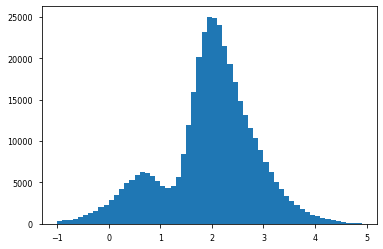

In [31]:
plt.hist(np.log10(zcat_elg['DELTACHI2']), bins = np.arange(-1, 5, .1));

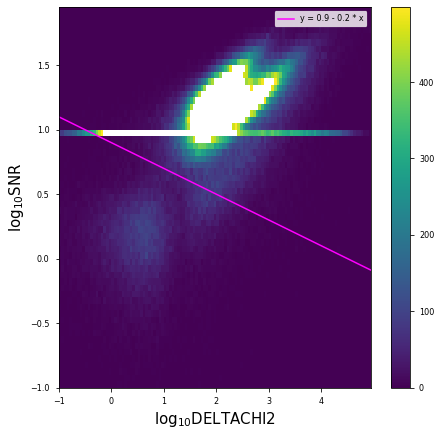

In [32]:
plt.figure(figsize = (7,7))
plt.hist2d(zcat_elg['log10_DELTACHI2'], zcat_elg['log10_OII_SNR'], 
           bins = [np.arange(-1, 5, .05), np.arange(-1,2, .05)], cmax = 500);
plt.plot(tmpx, oii_sel(tmpx), c = 'magenta', lw = 1.5, ls = 'solid', 
          label = 'y = 0.9 - 0.2 * x')
plt.xlabel(r"$\log_{10} {\rm DELTACHI2}$", fontsize = 15)
plt.ylabel(r"$\log_{10} {\rm SNR}$", fontsize = 15)
plt.legend(loc = 'best')
plt.colorbar()

These spurious 1 values are actually astro mask values as described in the previous section. We will explicitly mark these as "bad" galaxies later on. 

## Condition for [O II] flux based cut

In [29]:
is_oii_good = (zcat_elg['log10_OII_SNR']) > oii_sel(zcat_elg['log10_DELTACHI2'])

Note that we need to classify bad regions where QSOs and SPECTYPE STAR cluster (if any)

## FDR cut for plotting purposes

In [30]:
#DEFINE FDR CUT FOR PLOTTING PURPOSES

def fdr_plot(axs):
    #rz 0.15 cut 
    rz3_x = .15 * np.ones(10)
    rz3_y = np.linspace(-.5, .18, 10)
    
    #rz 1.6 cut
    rz16_x = 1.6 * np.ones(100)
    rz16_y = np.linspace(-.5, -.32, 100)
    
    #star/lowz cut
    lowz_x = np.arange(0.15, 15/17, .01)
    #lowzSouth_y = 1.15 * lowz_x -.15
    #lowzNorth_y = 1.15 * lowz_x -.20
    lowz_y = 0.5 * lowz_x + 0.1
    
    # [O II] cut
    OIIx = np.arange(15/17, 1.6, .01)
    OIIy = -1.2 * OIIx + 1.6
       
    axs.plot(rz3_x, rz3_y, c = 'magenta')
    axs.plot(rz16_x, rz16_y, c = 'k')
    axs.plot(OIIx, OIIy, c = 'y', label = '[O II] cut')
    axs.plot(lowz_x, lowz_y, c = 'r', label = 'lowz cut')
    #axs.legend(loc = 'best')

## Statistics of bad ELGs

### Condition for galaxies with no or negative OII fluxes

In [31]:
#define flag for galaxies with no OII flux or negative OII flux
is_bad_flux = zcat_elg['log10_OII_SNR'].mask

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


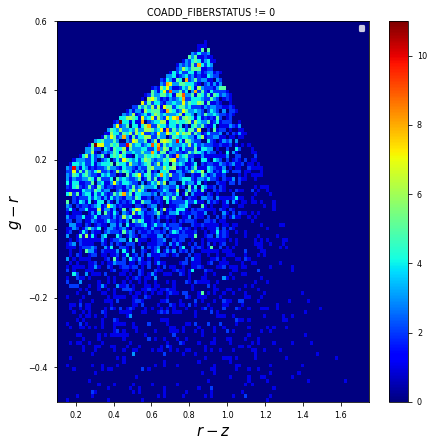

In [32]:
plt.figure(figsize = (7,7))
plt.hist2d(zcat_good_photsys['r-z'][~is_coadd_good_photsys], zcat_good_photsys['g-r'][~is_coadd_good_photsys], 
            bins = 100, cmap = plt.cm.jet, range = range2d, vmin = vmin);
plt.xlabel(r"$r-z$", fontsize = 15)
plt.ylabel(r"$g-r$", fontsize = 15)
plt.title("COADD_FIBERSTATUS != 0 ")
plt.legend(loc = 'best')
plt.colorbar()

Text(0.02, 0.5, 'g-r')

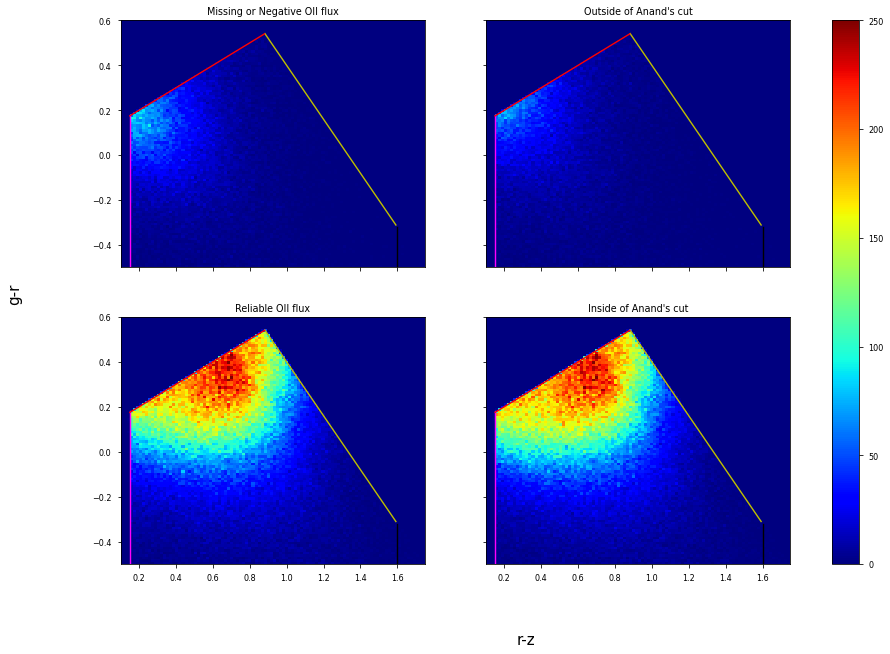

In [37]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize = (15, 10))

axs[0, 0].hist2d(zcat_elg['r-z'][is_bad_flux], zcat_elg['g-r'][is_bad_flux], 
                 bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[0,0].set_title("Missing or Negative OII flux")
fdr_plot(axs[0,0])

axs[1,1].hist2d(zcat_elg['r-z'][is_oii_good], zcat_elg['g-r'][is_oii_good], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[1,1].set_title("Inside of Anand's cut")
fdr_plot(axs[1,1])

axs[1,0].hist2d(zcat_elg['r-z'][~is_bad_flux], zcat_elg['g-r'][~is_bad_flux], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[1,0].set_title("Reliable OII flux")
fdr_plot(axs[1,0])

im = axs[0,1].hist2d(zcat_elg['r-z'][~is_oii_good], zcat_elg['g-r'][~is_oii_good], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[0,1].set_title("Outside of Anand's cut")
fdr_plot(axs[0,1])

#add common colorbar
fig.colorbar(im[3], ax=axs.ravel().tolist())

# hide tick and tick label of the big axis
fig.supxlabel('r-z', fontsize = 15)
fig.supylabel('g-r', fontsize = 15)

### Observation
Unreliable OII flux measurements and Anand's cut coincides. But the relative density is low. We have to measure the relative occurance of failure modes in those regions compared to outside. 

## Test 3: Does `SPECTYPE != GALAXY` cluster?

What percentage of misclassified `SPECTYPE` are STAR and QSO?

In [33]:
print(f"frac of QSO: {(zcat_elg['SPECTYPE'] == 'QSO').sum()/len(zcat_elg) * 100}")
print(f"frac of STAR: {(zcat_elg['SPECTYPE'] == 'STAR').sum()/len(zcat_elg) * 100}")

frac of QSO: 4.952041900907939
frac of STAR: 0.19644252071354482


### Condition for SPECTYPE

In [34]:
is_spectype = (zcat_elg['SPECTYPE'] == 'GALAXY')

In [35]:
vmax = 50

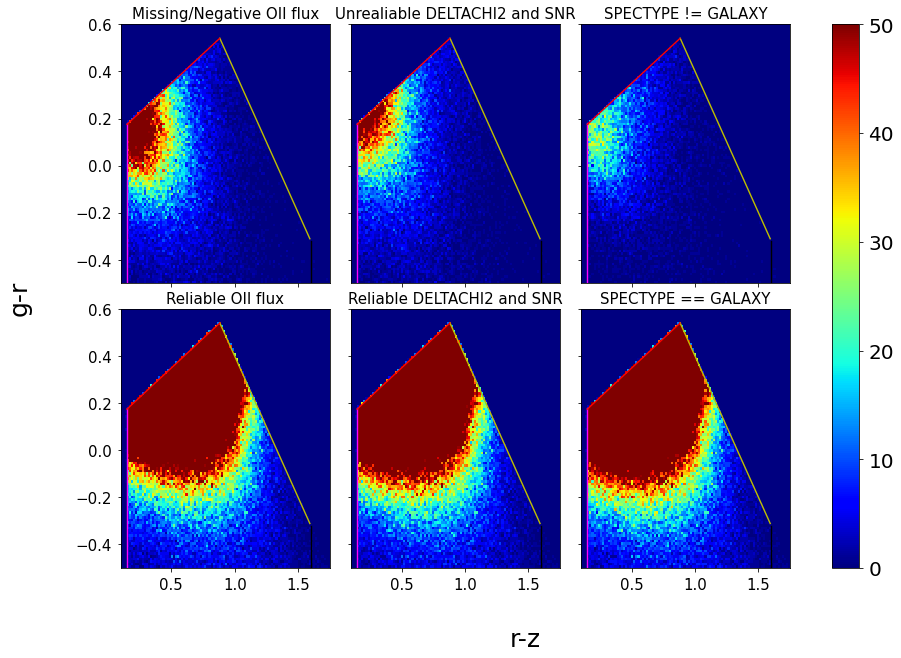

In [56]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (15, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

axs[0, 0].hist2d(zcat_elg['r-z'][is_bad_flux], zcat_elg['g-r'][is_bad_flux], 
                 bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[0,0].set_title("Missing/Negative OII flux", fontsize = 15)
fdr_plot(axs[0,0])
#axs[0,0].tick_params(axis='both', which='major', labelsize=15)
#axs[0,0].tick_params(axis='both', which='minor', labelsize=10)

axs[1,1].hist2d(zcat_elg['r-z'][is_oii_good], zcat_elg['g-r'][is_oii_good], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[1,1].set_title("Reliable DELTACHI2 and SNR", fontsize = 15)
fdr_plot(axs[1,1])
#axs[1,1].tick_params(axis='both', which='major', labelsize=15)
#axs[1,1].tick_params(axis='both', which='minor', labelsize=10)

axs[1,0].hist2d(zcat_elg['r-z'][~is_bad_flux], zcat_elg['g-r'][~is_bad_flux], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[1,0].set_title("Reliable OII flux", fontsize = 15)
fdr_plot(axs[1,0])
#axs[1,0].tick_params(axis='both', which='major', labelsize=15)
#axs[1,0].tick_params(axis='both', which='minor', labelsize=10)

im = axs[0,1].hist2d(zcat_elg['r-z'][~is_oii_good], zcat_elg['g-r'][~is_oii_good], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[0,1].set_title("Unrealiable DELTACHI2 and SNR", fontsize = 15)
fdr_plot(axs[0,1])

axs[0,2].hist2d(zcat_elg['r-z'][~is_spectype], zcat_elg['g-r'][~is_spectype], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[0,2].set_title("SPECTYPE != GALAXY", fontsize = 15)
fdr_plot(axs[0,2])

axs[1,2].hist2d(zcat_elg['r-z'][is_spectype], zcat_elg['g-r'][is_spectype], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[1,2].set_title("SPECTYPE == GALAXY", fontsize = 15)
fdr_plot(axs[1,2])
#axs[1,2].tick_params(axis='both', which='major', labelsize=15)
#axs[1,2].tick_params(axis='both', which='minor', labelsize=10)

#add common colorbar
cbar = fig.colorbar(im[3], ax=axs.ravel().tolist())

#cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
        
# hide tick and tick label of the big axis
fig.supxlabel('r-z', fontsize = 25)
fig.supylabel('g-r', fontsize = 25)

axs[0,0].tick_params(axis='both', which='major', labelsize=15)
axs[1,0].tick_params(axis='both', which='major', labelsize=15)
axs[1,0].tick_params(axis='both', which='minor', labelsize=10)
axs[1,1].tick_params(axis='both', which='major', labelsize=15)
axs[1,1].tick_params(axis='both', which='minor', labelsize=10)
axs[1,2].tick_params(axis='both', which='major', labelsize=15)
axs[1,2].tick_params(axis='both', which='minor', labelsize=10)


axs[0,0].grid(visible = False)
axs[0,1].grid(visible = False)
axs[0,2].grid(visible = False)
axs[1,0].grid(visible = False)
axs[1,1].grid(visible = False)
axs[1,2].grid(visible = False)

plt.savefig("../figures/clustering_spec_properties.pdf", dpi = 300, bbox_inches = 'tight')

### Observation
Yes they cluster the same way.

## Selection for bad galaxies

These either have missing or negative fluxes

In [44]:
misc_bad_bin_notspec = is_bad_flux | (~(is_oii_good.filled(False))) #bad bin definition except spec type

## $g_{\rm fib}$ cut off and its impact on dndz

We investigate whether a fiber magnitude based cut preferentially selects for ELG targets we desire.

% of SV3 sample discarded due to g_fib threshold: 1.5566853205957305


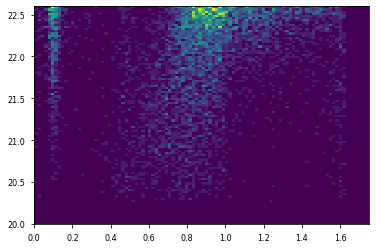

In [46]:
g_fib_threshold = 22.6
tmpsel_fib = (zcat_elg['gfib'] < g_fib_threshold) & (~misc_bad_bin_notspec)
tmpselneg_fib = (zcat_elg['gfib'] >= g_fib_threshold) & (~misc_bad_bin_notspec)

print(f'% of SV3 sample discarded due to g_fib threshold: {tmpsel_fib.sum()/len(tmpsel_fib) * 100}')
plt.hist2d(zcat_elg['Z'][tmpsel_fib], zcat_elg['gfib'][tmpsel_fib], bins = 100, 
           range = np.array([[0, 1.75], [20, g_fib_threshold]]));

Text(0.5, 1.0, 'gfib threshold: 22.6')

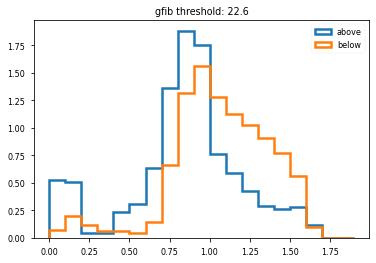

In [47]:
plt.hist(zcat_elg['Z'][tmpsel_fib], bins = np.arange(0, 2, 0.1), histtype= 'step', label = 'above', lw = 2.5, density = True)
plt.hist(zcat_elg['Z'][tmpselneg_fib], bins = np.arange(0, 2, 0.1), histtype= 'step', label = 'below', lw = 2.5, density = True)
plt.legend(loc = 'best')
plt.title(f"gfib threshold: {g_fib_threshold}")

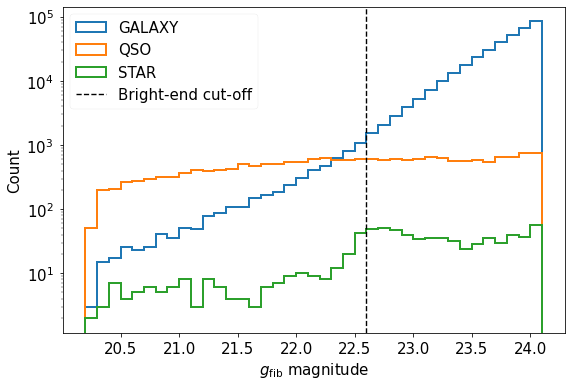

In [53]:
plt.figure(figsize=(9, 6))
for typ in ['GALAXY', 'QSO', 'STAR']:
    tmpflag = (zcat_elg['SPECTYPE'] == typ)# & (~misc_bad_bin_notspec)
    plt.hist(zcat_elg[tmpflag]['gfib'], bins = np.arange(20.2, 24.1, 0.1), label = typ, histtype= 'step',
            lw = 2, density = False)
plt.yscale("log")
plt.axvline(g_fib_threshold, c = 'k', ls = '--', label = 'Bright-end cut-off')
plt.legend(loc = 'upper left', fontsize = 15)
plt.xlabel(r"$g_{\rm fib}$ magnitude", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("../figures/gfib_cut.pdf", bbox_inches = 'tight', dpi = 450)

In [49]:
g_fib_threshold = 22.6
tmpsel_fib = (zcat_elg['gfib'] < g_fib_threshold) #& (~misc_bad_bin_notspec)
tmpselneg_fib = (zcat_elg['gfib'] >= g_fib_threshold) #& (~misc_bad_bin_notspec)

print(f'% of SV3 sample discarded due to g_fib threshold: {tmpsel_fib.sum()/len(tmpsel_fib) * 100}')

% of SV3 sample discarded due to g_fib threshold: 3.9260331160598803


In [178]:
for typ in ['GALAXY', 'QSO', 'STAR']:
    print(typ)
    print(f"% obj below threshold: {(zcat_elg[tmpsel_fib]['SPECTYPE'] == typ).sum()/len(zcat_elg[tmpsel_fib])}")
    print(f"% obj above threshold: {(zcat_elg[tmpselneg_fib]['SPECTYPE'] == typ).sum()/len(zcat_elg[tmpselneg_fib])}")
    print("----")

GALAXY
% obj below threshold: 0.33524691760714986
% obj above threshold: 0.9735761737702471
----
QSO
% obj below threshold: 0.6519016243721052
% obj above threshold: 0.024904296271020164
----
STAR
% obj below threshold: 0.012851458020744994
% obj above threshold: 0.0015195299587327654
----


## Assign tomographic labels
- Make three bins with spec- $z < 0.6$, $0.6 < z < 1.65$, and bad labels as $0$, $1$ and $2$ respectively. 

In [57]:
# three bins, low-z interloper, highz (1.1 < z < 1.65) and bad 

pivot = 0.6
misc_bad_bin = (~is_spectype) | is_bad_flux | (~(is_oii_good.filled(False))) #either spectype does not match GALAXY, flux is missing or negative or does not meet Raichoo et al. 2022 cut
lowz_interloper_bin = (zcat_elg['Z'] < pivot) & (~misc_bad_bin)
main_bin = ((zcat_elg['Z'] >= pivot) & (zcat_elg['Z'] <= 1.65)) & (~misc_bad_bin)

#assign labels
bin_cat = -99 * np.ones(len(zcat_elg))
bin_cat[misc_bad_bin] = 2 #bad bin label
bin_cat[lowz_interloper_bin] = 0 
bin_cat[main_bin] = 1

In [58]:
for i in range(len(np.unique(bin_cat))):
    print(f"% of ELGs in bin {i} is: {(bin_cat == i).sum()/len(bin_cat)}")

% of ELGs in bin 0 is: 0.04320967101640436
% of ELGs in bin 1 is: 0.7123205573128097
% of ELGs in bin 2 is: 0.2444697716707859


In [59]:
# make labels int
zcat_elg['bin_label'] = bin_cat.astype(int)

In [62]:
# check uniqueness of rows
len(zcat_elg['TARGETID']) == len(np.unique(zcat_elg['TARGETID']))

True

# Classification of the tomographic bins with `sklearn`

In [18]:
from sklearn.metrics import accuracy_score, roc_curve, plot_confusion_matrix, confusion_matrix, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## Full sample with 2 labels
In this training, we do not make any colour cuts and use an additional label for bad pixels

In [63]:
#only focus on region of interest in the colour-colour space
is_not_incomplete = (zcat_elg['g-r'] > -.4) & (zcat_elg['g-r'] < .5) & (zcat_elg['r-z'] < 1.25) & (zcat_elg['r-z'] > 0.1) & \
(zcat_elg['SHAPE_R'] < 1.5) & (zcat_elg['gfib'] >= 22.6) & (zcat_elg['zfib'] <= 25.5) & \
(zcat_elg['rfib'] <= 27.5) & (zcat_elg['MAG_R'] <= 27) & (zcat_elg['MAG_Z'] <= 25) #parts of the colour-colour space that do not have enough points

cond = is_not_incomplete & (~misc_bad_bin) # good targets
cond_bad = is_not_incomplete & misc_bad_bin # label 2 targets

In [64]:
print(f"good: {cond.sum()}")
print(f"total: {(len(cond))}")
print(f"bad: {(cond_bad).sum()} and %: {(cond_bad).sum()/(len(cond)) * 100}")

good: 277130
total: 390445
bad: 78115 and %: 20.006659068498763


In [65]:
np.count_nonzero(cond==cond_bad)

35200

In [66]:
np.sum(cond[np.where(cond == cond_bad)])

0

The overlaps between `cond` and `cond_bad` are only in `False` values. Since this implies they won't be counted into our sample, we do not care 

### Plot of the footprint
To be used in paper to show SV3 footprint

In [67]:
# make astropy Table
tmpdata = zcat_elg[cond | cond_bad] 

Now we find the appropriate rosette numbers of the corresponding ELGs so that we may use this information for training purposes. In SV3 fuji, there are 20 tiles for ELGs. Our strategy is to use $80\% = 16$ of the tiles for training and the rest $4$ for testing. We will split these tiles into two halves to increase the number of unique training and test sets and boostrap the redshift distribution calculation $1000$ times to get uncertainty estimates.

In [68]:
# read files with rosette info
tmptmp = fits.open('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/fuji/LSScats/3.1/ELG_full_noveto.dat.fits')

is_in_lss_cat = match_to(tmptmp[1].data['TARGETID'], tmpdata['TARGETID'])
lss_elg = tmptmp[1].data[is_in_lss_cat]

We have to remove targets that do not match in the lss catalogue. 

In [69]:
len(tmpdata) - len(lss_elg)

4

In [70]:
tid_del = []
for tid in np.setdiff1d(tmpdata['TARGETID'], lss_elg['TARGETID']):
    tid_del.append(np.where(tmpdata['TARGETID'] == tid)[0][0])
    
tid_del = np.array(tid_del)
tmpdata.remove_rows(tid_del)

In [71]:
# verify same number of objects
len(tmpdata) == len(lss_elg)

True

Verify that the rows match 

In [74]:
(tmpdata['TARGETID'] == lss_elg['TARGETID']).sum() - len(tmpdata)

0

Pass rosette number information from lss catalogue to our analysis catalogue. 

In [75]:
tmpdata['rosette_number'] = lss_elg['rosette_number']

### Footprint

In [77]:
footprint = utilsAstro.hpixsum(nside = 512, ra = np.array(tmpdata['TARGET_RA']), dec = np.array(tmpdata['TARGET_DEC'])).astype(np.float)

/tmp/ipykernel_56917/1024485808.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  footprint = hpixsum(nside = 512, ra = np.array(tmpdata['TARGET_RA']), dec = np.array(tmpdata['TARGET_DEC'])).astype(np.float)


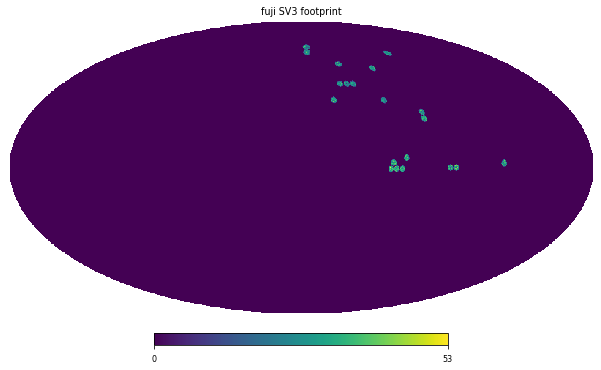

In [78]:
hp.mollview(footprint, rot = -85, cmap = 'viridis', title = 'fuji SV3 footprint')
plt.savefig("../figures/sv3_footprint.pdf", dpi = 400, bbox_inches = 'tight')

### Create training set

In [79]:
zcat_elg_complete = tmpdata[['TARGETID', 'TARGET_RA', 'TARGET_DEC', 
                             'SPECTYPE', 'rosette_number', 'SHAPE_R', "MAG_G", "MAG_R", "MAG_Z", 
                             'g-r', 'r-z', 'gfib', 'rfib', 'zfib', 'Z', 'bin_label']]

In [80]:
# ensure each rows are unique
len(zcat_elg_complete) - len(np.unique(np.array(zcat_elg_complete['TARGETID'])))

0

In [81]:
# mix up the rows
df = zcat_elg_complete.to_pandas()
df = df.sample(frac = 1, replace = False, random_state = 45)
df = df.reset_index(drop = True)
df.head()

,TARGETID,TARGET_RA,TARGET_DEC,SPECTYPE,rosette_number,SHAPE_R,MAG_G,MAG_R,MAG_Z,g-r,r-z,gfib,rfib,zfib,Z,bin_label
0,39627781780277554,184.362351,-0.289296,b'QSO',2.0,0.000000,23.411702,23.240456,22.839370,0.171246,0.401086,23.685067,23.513821,23.112735,1.846289,2
1,39632951842964517,253.022667,33.602912,b'GALAXY',14.0,0.000000,23.550719,23.761088,23.413711,-0.210370,0.347378,23.822195,24.032565,23.685187,1.486535,1
2,39628459885988840,195.275319,28.957184,b'GALAXY',4.0,0.869456,22.599111,22.336956,21.879165,0.262155,0.457791,23.815420,23.553264,23.095473,0.088913,2
3,39627818010674036,183.795197,1.166600,b'GALAXY',2.0,0.000000,23.319172,22.997021,22.329896,0.322151,0.667124,23.592388,23.270237,22.603112,1.164192,1
4,39627752176878562,219.784088,-1.377008,b'GALAXY',9.0,0.321595,23.548393,23.258626,22.334236,0.289766,0.924391,24.041600,23.751834,22.827443,0.903435,1


In [84]:
df.loc[(df.bin_label == 2), 'Z'] = -99 #set all bad redshifts to -99 to distinguish

In [85]:
df['Z'].max()

1.6198079210989067

Check the stats of per label

In [86]:
df.groupby('bin_label').count()#/df.groupby('bin_label').count()['r-z'].sum()

,TARGETID,TARGET_RA,TARGET_DEC,SPECTYPE,rosette_number,SHAPE_R,MAG_G,MAG_R,MAG_Z,g-r,r-z,gfib,rfib,zfib,Z
bin_label,,,,,,,,,,,,,,,
0,14840,14840,14840,14840,14840,14840,14840,14840,14840,14840,14840,14840,14840,14840,14840
1,262287,262287,262287,262287,262287,262287,262287,262287,262287,262287,262287,262287,262287,262287,262287
2,78114,78114,78114,78114,78114,78114,78114,78114,78114,78114,78114,78114,78114,78114,78114


### split rosette into equal areas 

In [88]:
#split using mean of DEC 
tmptransformed = df.groupby("rosette_number").TARGET_DEC.transform(lambda x : x > x.mean()) 
df['half_rosetteID'] = 2*df.rosette_number + tmptransformed

In [89]:
#reorder 
df = df[['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'SPECTYPE', 'rosette_number', 'half_rosetteID', 
         'SHAPE_R', 'MAG_G', 'MAG_R', 'MAG_Z', 'g-r', 'r-z', 'gfib', 'rfib', 
         'zfib', 'Z', 'bin_label']]

#### check whether split worked
We take the first half of `rosette_number == 0` and then the second half, plotting them on the sky. We also overlay the mean DEC of the same rosette number and see if it is in the middle. 

In [90]:
tmpdf0 = df[df['half_rosetteID'] == 0]
tmpdf1 = df[df['half_rosetteID'] == 1]
tmpdecmean = df.groupby("rosette_number")['TARGET_DEC'].mean()[0]

Text(0, 0.5, 'RA')

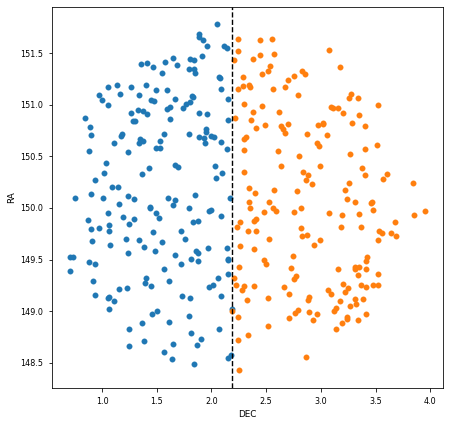

In [91]:
plt.figure(figsize=(7,7))
sample_rate = 50
plt.scatter(tmpdf0['TARGET_DEC'][::sample_rate], tmpdf0['TARGET_RA'][::sample_rate])
plt.scatter(tmpdf1['TARGET_DEC'][::sample_rate], tmpdf1['TARGET_RA'][::sample_rate])
plt.axvline(tmpdecmean, ls = '--', c = 'k')
plt.xlabel("DEC")
plt.ylabel("RA")

Save data file for future use

In [93]:
df.to_pickle("/global/cscratch1/sd/tanveerk/final_data_products/elgXplanck/fuji-elg-single-tomo.pkl")

In [14]:
df = pd.read_pickle("/pscratch/sd/t/tanveerk/final_data_products/elgXplanck/fuji-elg-single-tomo.pkl")

### Standardize features for training purposes

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle

X, y = df.drop(["bin_label"], axis=1), df["bin_label"].values

#scale features
sc = StandardScaler()
X_transformed = sc.fit_transform(X.iloc[:,7:-1])
X_transformed =  np.hstack((np.array(X.iloc[:,:7]), X_transformed)) #concatenate identifying information

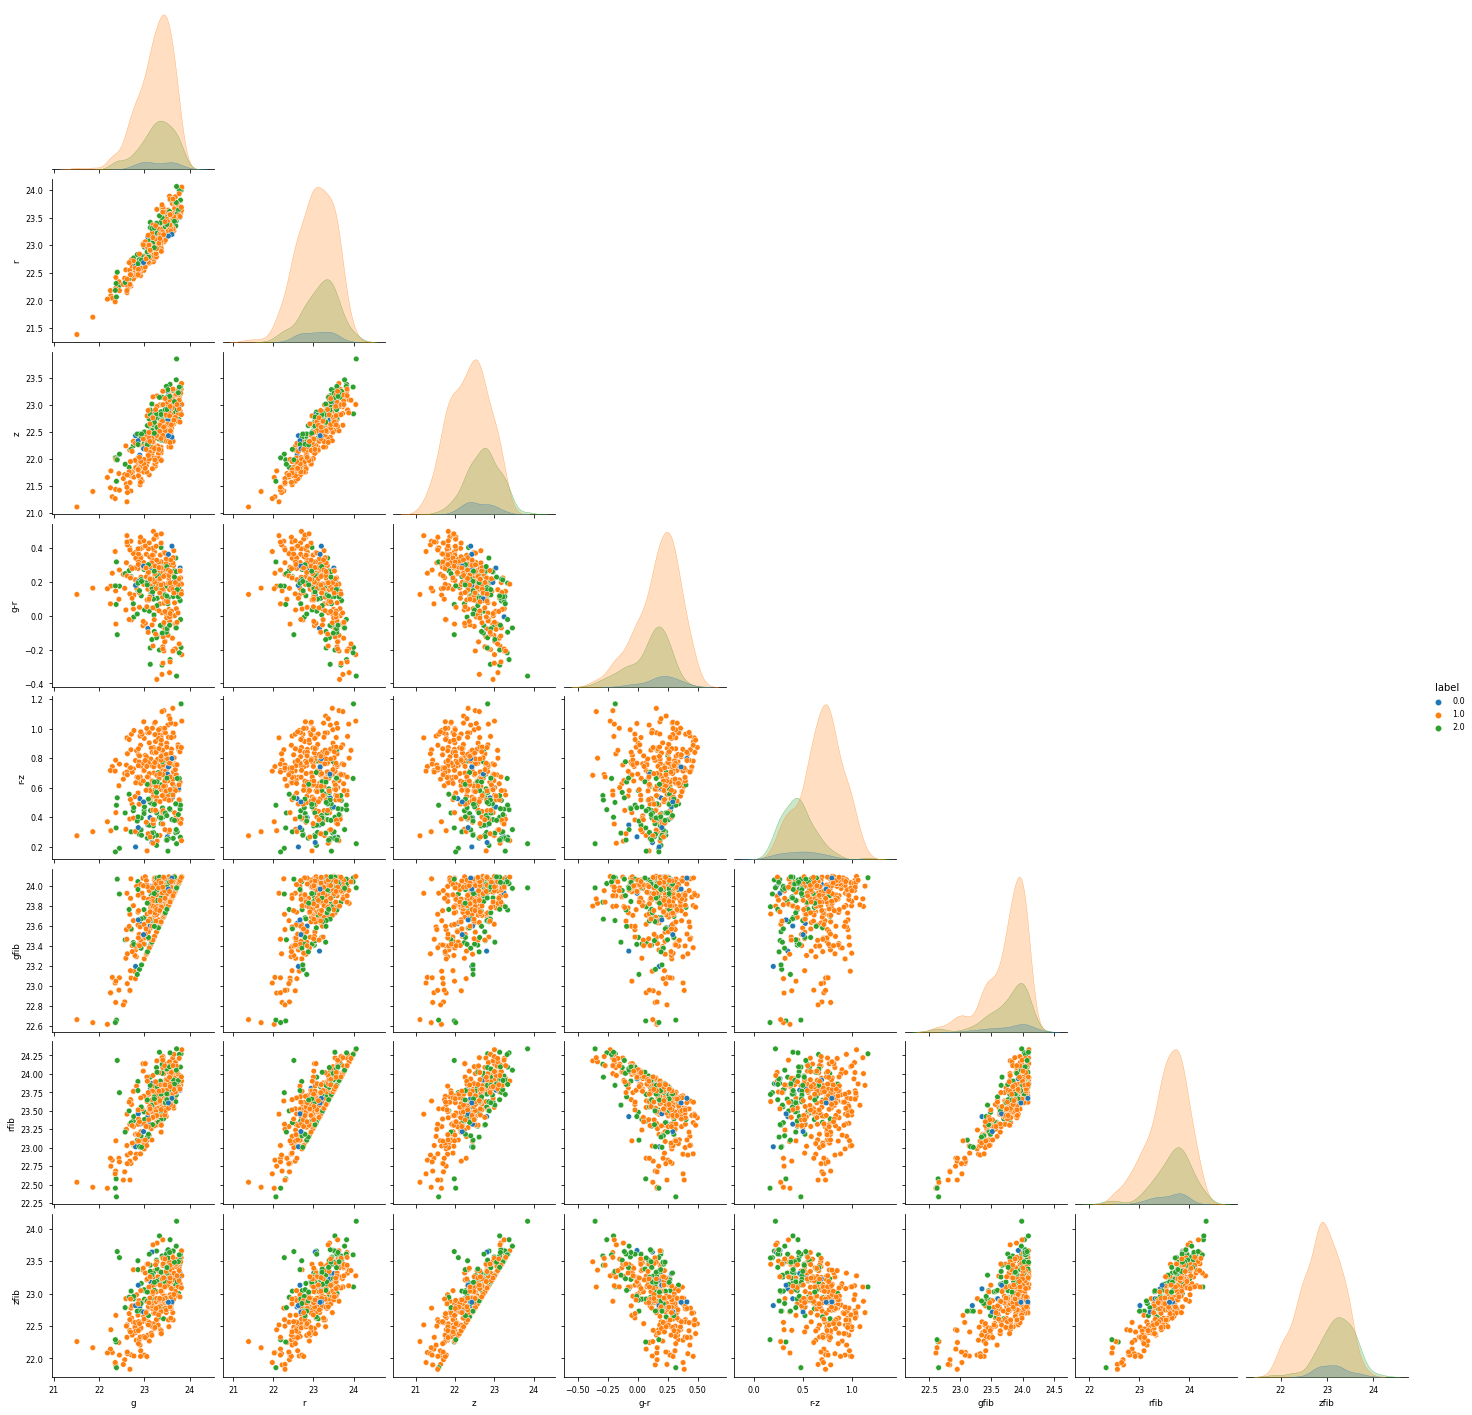

In [30]:
import seaborn as sns
sns.pairplot(pd.DataFrame(np.hstack((np.array(X.iloc[::1000,7:-1]), y[::1000].reshape(-1,1))), 
                          columns=['g','r','z', 'g-r', 'r-z', 'gfib', 'rfib', 'zfib', 'label']), 
             hue = 'label', palette="tab10", corner = True)

#### Randomly select rosettes for train and test
We want to split the rosettes into $32$ training and $8$ test tiles. We will use the principle of bootstrapping that has a better statistical behaviour than jackknifing. Our procedure is as follows:
- Split indices from 0 - 39 into sub-samples without replacement of test and training sets. We make this split at the beginning before boostrapping to ensure that the training and test rosettes are unique. 
- Next we sample the training and test indices sub-samples with the same size. This step is the boostrap step where we uniformly sample with replacement potential training and test rosettes. 
- This procedure is repeated $1000$ times to get a statistical distribution of the dndz. 

In [6]:
# define indices range and size of the sub-samples
idxrange = np.arange(20*2)
tst_sz = 4*2
trn_sz = 16*2

In [7]:
# split indices without replacement into train and test sub-samples.
rng = np.random.default_rng(202211)
tmp_tst_rosetteID = rng.choice(idxrange, tst_sz, replace = False)
tmp_trn_rosetteID = np.setxor1d(idxrange, tmp_tst_rosetteID)
print(tmp_tst_rosetteID)
print(tmp_trn_rosetteID)

[22 32 19 17  6  7  1 15]
[ 0  2  3  4  5  8  9 10 11 12 13 14 16 18 20 21 23 24 25 26 27 28 29 30
 31 33 34 35 36 37 38 39]


In [ ]:
np.unique(X_transformed[:,5]).shape

In [8]:
# identify indices of test and training sets
indices_trn = []
indices_tst = []

for ii in range(len(tmp_trn_rosetteID)):
    indices_trn.append(np.where(X_transformed[:,5] == tmp_trn_rosetteID[ii])[0])
    
for ii in range(len(tmp_tst_rosetteID)):
    indices_tst.append(np.where(X_transformed[:,5] == tmp_tst_rosetteID[ii])[0])
    
#turn into numpy array
indices_trn = np.concatenate(indices_trn)
indices_tst = np.concatenate(indices_tst)

#shuffle indices
rng.shuffle(indices_trn)
rng.shuffle(indices_tst)

In [9]:
# stats of train to test ratio
print(len(indices_tst)/(len(indices_trn) + len(indices_tst)))

0.2013224824837223


In [10]:
# splice training and test sets
X_trn = X_transformed[indices_trn, :]
X_tst = X_transformed[indices_tst, :]

y_trn = y[indices_trn]
y_tst = y[indices_tst]

Verify that indeed bootstrapping worked as intended

We notice that in the test set there are two unique rosettes. We plot the footprint of the test set and indeed notice only two rosettes plotted, verifying our method.

/tmp/ipykernel_59360/2998445232.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ra = X_tst[:,1].astype(np.float),
/tmp/ipykernel_59360/2998445232.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dec = X_tst[:,2].astype(np.float))


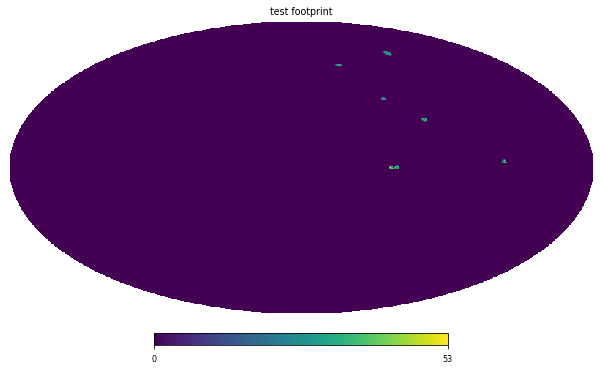

In [13]:
footprint = utilsAstro.hpixsum(nside = 512, 
                    ra = X_tst[:,1].astype(np.float), 
                    dec = X_tst[:,2].astype(np.float))

hp.mollview(footprint, rot = -85, cmap = 'viridis', title = 'test footprint')

In [14]:
# verify that there is no overlap between training and test sets
np.intersect1d(X.loc[indices_trn]['TARGETID'], X.loc[indices_tst]['TARGETID'])

array([], dtype=int64)

In [15]:
# stats for if objects were assigned labels at random, what the probabilities would be 

for i in range(len(np.unique(y_tst))):
    print(f"Baseline performance: for label {i} is {np.round(np.count_nonzero(y == i)/len(y), 2)}")

Baseline performance: for label 0 is 0.04
Baseline performance: for label 1 is 0.74
Baseline performance: for label 2 is 0.22


In [16]:
for i in range(len(np.unique(y_tst))):
    print(f"Baseline set: for label {i} is {(y == i).sum()}")
    print(f"Baseline training set: for label {i} is {(y_trn == i).sum()/len(y_trn) * 100}")
    print(f"Baseline test set: for label {i} is {(y_tst == i).sum()/len(y_tst) * 100}")

Baseline set: for label 0 is 14840
Baseline training set: for label 0 is 4.1903546769207995
Baseline test set: for label 0 is 4.126233955088229
Baseline set: for label 1 is 262287
Baseline training set: for label 1 is 73.62638911896462
Baseline test set: for label 1 is 74.65533152493079
Baseline set: for label 2 is 78114
Baseline training set: for label 2 is 22.183256204114578
Baseline test set: for label 2 is 21.218434519980985


### Train Random Forest Classifier

In [19]:
clf=RandomForestClassifier(class_weight={0: 0.325, 1: 0.35, 2: 0.325},
                       max_features='sqrt', min_samples_leaf=10,
                       min_samples_split=10, n_estimators=20) #based on randomsearchCV tuning 

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_trn[:,7:], y_trn.astype(int))
y_prd = clf.predict(X_tst[:,7:])

Training takes an average of $34$ s on Cori and $27.4$ s on Perlmutter. So over $10$ nodes, should take $1$ hour each.

In [20]:
# predict on the training sets
y_pred_trn = clf.predict(X_trn[:,7:])

### Training performance

In [23]:
print("Accuracy:",accuracy_score(y_tst, y_prd))
print("Feature importance:",clf.feature_importances_)
print(X.columns[7:-1])

for kk in range(len(clf.feature_importances_)):
    print(f"Feature: {X.columns[7:-1][kk]}, importance: {clf.feature_importances_[kk]}")
    print("---")

Accuracy: 0.7729942112475181
Feature importance: [0.07173664 0.07905923 0.15450451 0.07651042 0.31893041 0.07720603
 0.07951377 0.142539  ]
Index(['MAG_G', 'MAG_R', 'MAG_Z', 'g-r', 'r-z', 'gfib', 'rfib', 'zfib'], dtype='object')
Feature: MAG_G, importance: 0.07173663742982342
---
Feature: MAG_R, importance: 0.07905923086937602
---
Feature: MAG_Z, importance: 0.15450450974916877
---
Feature: g-r, importance: 0.07651042189111162
---
Feature: r-z, importance: 0.31893040513602255
---
Feature: gfib, importance: 0.07720603213804017
---
Feature: rfib, importance: 0.07951376700434327
---
Feature: zfib, importance: 0.14253899578211415
---


In [24]:
print("Accuracy in training:",accuracy_score(y_trn, y_pred_trn))

Accuracy in training: 0.8329849888799992


In [25]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, precision_score, recall_score, classification_report

In [26]:
print(classification_report(y_tst, y_prd))

              precision    recall  f1-score   support

           0       0.48      0.04      0.08      2951
           1       0.82      0.92      0.86     53392
           2       0.54      0.41      0.47     15175

    accuracy                           0.77     71518
   macro avg       0.61      0.46      0.47     71518
weighted avg       0.75      0.77      0.75     71518



In [27]:
print(accuracy_score(y_tst, y_prd))
print(precision_score(y_tst, y_prd, average='macro'))
print(recall_score(y_tst, y_prd, average='macro'))

0.7729942112475181
0.6121834157151725
0.45690540307086175


In [30]:
plt.rcParams.update({'font.size': 15})

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


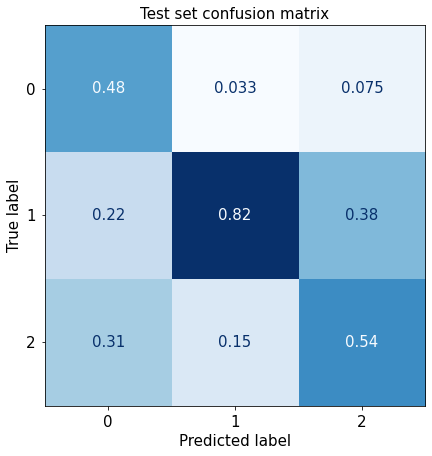

In [32]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(clf, X_tst[:,7:], y_tst, normalize='pred', cmap=plt.cm.Blues, ax=ax, colorbar = False)
plt.title("Test set confusion matrix", fontsize = 15)
plt.ylabel("True label", fontsize = 15)
plt.xlabel("Predicted label", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig("../figures/conf_matrix.pdf", dpi = 300, bbox_inches = 'tight')

First we plot each label in the training and the test sample and look at the qualitative distribution

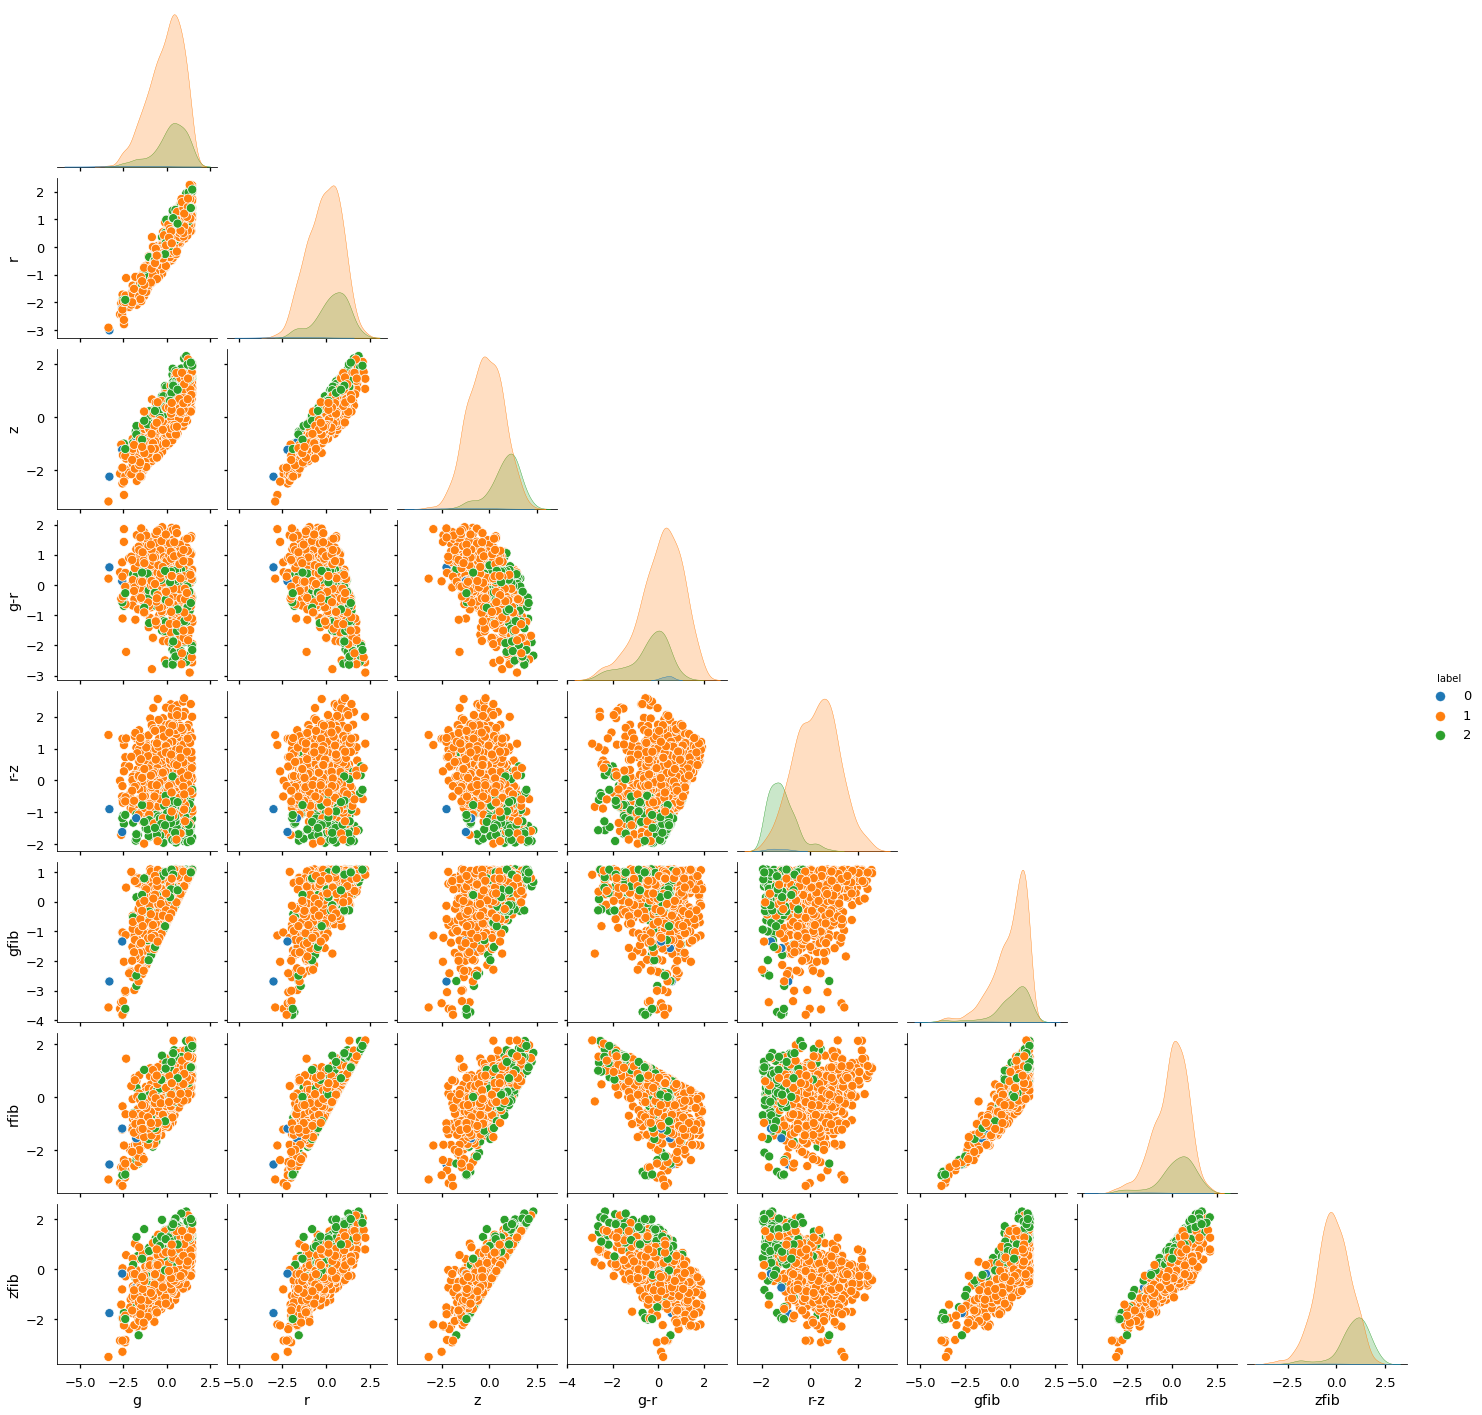

In [124]:
import seaborn as sns
sns.pairplot(pd.DataFrame(np.hstack((X_tst[::100,6:], y_prd[::100].reshape(-1,1))), columns=['g','r','z', 'g-r', 'r-z', 
                                                                              'gfib', 'rfib', 'zfib', 'label']), 
             hue = 'label', palette="tab10", corner = True)

Save random forest model

In [131]:
import pickle 
pickle.dump(clf, open("/global/cscratch1/sd/tanveerk/final_data_products/elgXplanck/fuji_RandomForestClassifier_single_tomo.pkl", 'wb'))

### Plot Redshift Distribution

% in tomo bin 2 with bad redshift: 0.14848830193738688


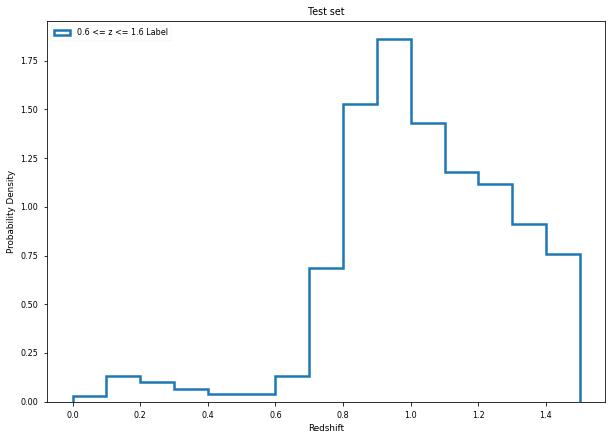

In [132]:
plt.figure(figsize=(10,7))
zrange = np.arange(0, 1.6, 0.1)

test_specz = X.iloc[indices_tst][y_prd == 1]['Z']
print(f"% in tomo bin {2} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_2 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "0.6 <= z <= 1.6 Label");

plt.legend(loc = 'upper left')
plt.title("Test set")
plt.xlabel("Redshift")
plt.ylabel("Probability Density")
plt.show()

% in tomo bin 1 with bad redshift: 0.2878787878787879
% in tomo bin 2 with bad redshift: 0.14848830193738688


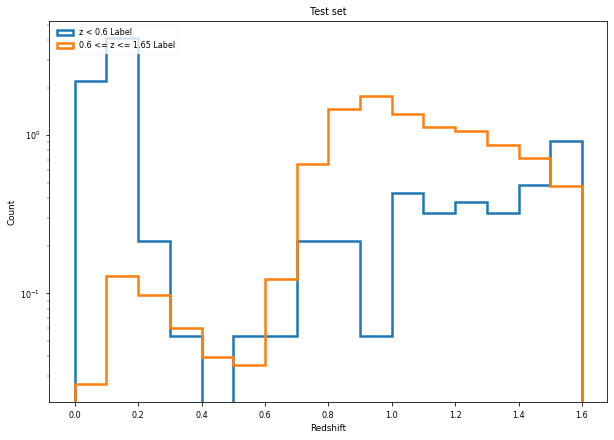

In [174]:
plt.figure(figsize=(10,7))
zrange = np.arange(0, 1.65, 0.1)

test_specz = X.iloc[indices_tst][y_prd == 0]['Z']
print(f"% in tomo bin {1} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_1 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "z < 0.6 Label");

test_specz = X.iloc[indices_tst][y_prd == 1]['Z']
print(f"% in tomo bin {2} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_2 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "0.6 <= z <= 1.65 Label");

#plt.plot(zrange, cmb_kernel(zrange)/cmb_kernel(zrange).max() * 2, label = 'CMB kernel (Arbitrary Units)', ls = '--', c = 'k')
#plt.yscale("log")
plt.legend(loc = 'upper left')
plt.title("Test set")
plt.xlabel("Redshift")
plt.ylabel("Count")
plt.yscale("log")
plt.show()

In [52]:
%time y_pred_balanced = clf.predict(X_balanced)

CPU times: user 9.22 s, sys: 128 ms, total: 9.35 s
Wall time: 9.35 s


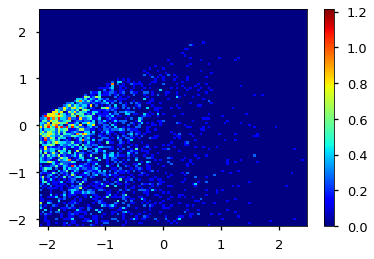

In [53]:
#tmptmp = (y_pred_balanced == 4)
tmptmp = (y_pred == 4)
# tmpa = plt.hist2d(X_balanced[:,0][tmptmp], X_balanced[:,1][tmptmp], bins = 100,  cmap = plt.cm.jet,
#                  density = True, range = [[X_balanced[:,0].min(), X_balanced[:,0].max()], [X_balanced[:,1].min(), X_balanced[:,1].max()]]);
tmpa = plt.hist2d(X_balanced[:,0][indices_test][tmptmp], 
                  X_balanced[:,1][indices_test][tmptmp], bins = 100,  cmap = plt.cm.jet,
                  density = True, range = [[X_balanced[:,0][indices_test][tmptmp].min(),
                                            X_balanced[:,0][indices_test][tmptmp].max()], 
                                           [X_balanced[:,0][indices_test][tmptmp].min(), 
                                            X_balanced[:,0][indices_test][tmptmp].max()]]);
plt.colorbar()
plt.show()

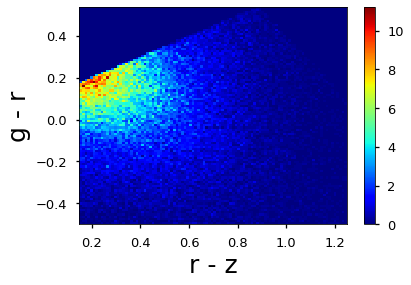

In [54]:
# plt.hist2d(mag_bad['r-z'], mag_bad['g-r'], 
#           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]], 
#           vmax = 180);
# tmpb = plt.hist2d(mag_good['r-z'][lowz_bad_bin & cond], mag_good['g-r'][lowz_bad_bin & cond], 
#            bins = 100, cmap = plt.cm.jet, range = [[.15, 1.3], [-0.5, .6]]);
# tmpb = plt.hist2d(mag_good['r-z'][tomo_1_bin & cond], mag_good['g-r'][tomo_1_bin & cond], 
#            bins = 100, cmap = plt.cm.jet, range = [[.15, 1.3], [-0.5, .6]]);
# tmpb = plt.hist2d(mag_good['r-z'][tomo_2_bin & cond], mag_good['g-r'][tomo_2_bin & cond], 
#            bins = 100, cmap = plt.cm.jet, range = [[.15, 1.3], [-0.5, .6]]);
# tmpb = plt.hist2d(mag_good['r-z'][highz_bad_bin & cond], mag_good['g-r'][highz_bad_bin & cond], 
#            bins = 100, cmap = plt.cm.jet, range = [[.15, 1.3], [-0.5, .6]]);
tmpb = plt.hist2d(mag_bad['r-z'][cond_bad], mag_bad['g-r'][cond_bad], 
           bins = 100, cmap = plt.cm.jet, range = [[mag_good['r-z'][cond].min(), mag_good['r-z'][cond].max()], 
                                                   [mag_good['g-r'][cond].min(), mag_good['g-r'][cond].max()]],
                  density = True);
# plt.plot(np.arange(4/9, 2/3, 0.01), np.arange(4/9, 2/3, 0.01) * 1.4 - 0.5, lw = 4.5, c = 'magenta')
# plt.plot(tmpx, tmpy, c = 'magenta', lw = 4.5)
# plt.plot(tmpxx, tmpyy, c = 'magenta', lw = 4.5)
#plt.title("ZWARN != 0")
plt.xlabel("r - z", fontsize = 25)
plt.ylabel("g - r", fontsize = 25)
plt.colorbar()
plt.show()

Text(0.5, 1.0, '(4, 1)')

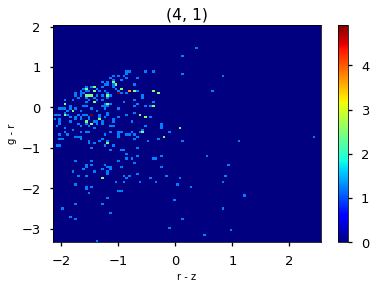

In [55]:
tupp = (4,1)
tmptmp = (y_pred_balanced == tupp[0]) & (y_balanced == tupp[1])
tmpa = plt.hist2d(X_balanced[:,0][tmptmp], X_balanced[:,1][tmptmp], bins = 100,  cmap = plt.cm.jet,
                 density = True, range = [[X_balanced[:,0].min(), X_balanced[:,0].max()], [X_balanced[:,1].min(), X_balanced[:,1].max()]]);
plt.colorbar()
plt.xlabel("r - z", fontsize = 10)
plt.ylabel("g - r", fontsize = 10)
plt.title(f"({tupp[0]}, {tupp[1]})")

In [184]:
from astropy.cosmology import Planck18
from astropy.constants import c

In [185]:
#plot CMB lensing kernel
def cmb_kernel(z):
    return 3/2 * Planck18.Om0/c * Planck18.H0**2/Planck18.H(z) * (1 + z) * Planck18.comoving_distance(z) * (1 - Planck18.comoving_distance(z)/Planck18.comoving_distance(1090))

In [156]:
for i in range (1,3):
    tmp_spectype = X_sampled[indices_test][(y_pred == i)]
    bad_redshift_cond = tmp_spectype[:,-1].astype(np.float) == -99 
    for stype in ['GALAXY', 'STAR', 'QSO']:
        #print("# of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {(tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()}")
        print("% of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {np.round((tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()/len(tmp_spectype[bad_redshift_cond]) * 100,2)}")
        #print("% overall of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {np.round((tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()/len(tmp_spectype) * 100,2)}")

/tmp/ipykernel_28146/1203028275.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bad_redshift_cond = tmp_spectype[:,-1].astype(np.float) == -99


% of bad redshifts belonging to SPECTYPE GALAXY in tomo bin 1 is 75.59
% of bad redshifts belonging to SPECTYPE STAR in tomo bin 1 is 0.75
% of bad redshifts belonging to SPECTYPE QSO in tomo bin 1 is 23.67
% of bad redshifts belonging to SPECTYPE GALAXY in tomo bin 2 is 90.38
% of bad redshifts belonging to SPECTYPE STAR in tomo bin 2 is 0.44
% of bad redshifts belonging to SPECTYPE QSO in tomo bin 2 is 9.17


% in tomo bin 1 with bad redshift: 0.07825510279271977
% in tomo bin 2 with bad redshift: 0.22476287803787565


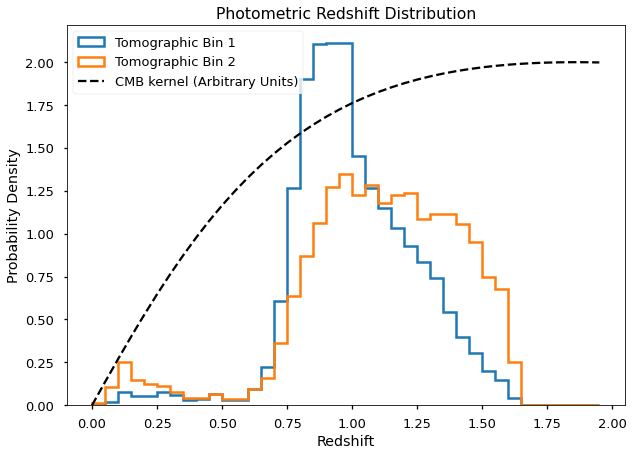

In [241]:
plt.figure(figsize=(10,7))
# tst_1 = plt.hist(X_sampled[indices_test][(y_test == 1)][X_sampled[indices_test][(y_test == 1)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");
# tst_2 = plt.hist(X_sampled[indices_test][(y_test == 2)][X_sampled[indices_test][(y_test == 2)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

zrange = np.arange(0, 2, 0.05)

test_specz = X.iloc[indices_test]['Z'][y_pred == 1]
print(f"% in tomo bin {1} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_1 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");

test_specz = X.iloc[indices_test]['Z'][y_pred == 2]
print(f"% in tomo bin {2} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_2 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

plt.plot(zrange, cmb_kernel(zrange)/cmb_kernel(zrange).max() * 2, label = 'CMB kernel (Arbitrary Units)', ls = '--', c = 'k')
#plt.yscale("log")
plt.legend(loc = 'upper left')
plt.title("Photometric Redshift Distribution")
plt.xlabel("Redshift")
plt.ylabel("Probability Density")
plt.show()
#plt.savefig("../plots/tomo_dndz.pdf", bbox_inches = 'tight', dpi = 450)

In [148]:
X.loc[indices_test][y_pred == 1]['Z'] == -99

33464     False
113208    False
180389    False
333935    False
288065    False
          ...  
78338     False
175483    False
182724     True
349109    False
112919     True
Name: Z, Length: 27230, dtype: bool

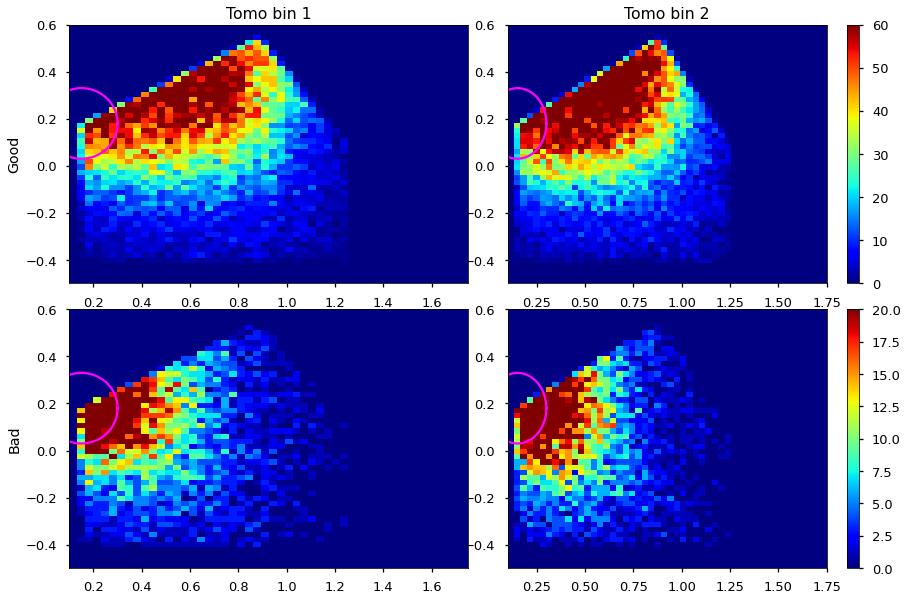

In [150]:
fig, axs = plt.subplots(2,2, figsize = (15, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

imall = {}
imbad = {}

for i in range(1,3):
    tmp_spectype = X.loc[indices_test][(y_pred == i)]
    bad_redshift_cond = (tmp_spectype['Z'] == -99)
    
    #histogram all data
    imall[i] = axs[0, i-1].hist2d(tmp_spectype['r-z'], tmp_spectype['g-r'], 
                    bins = 50, cmap = plt.cm.jet, vmin = vmin, vmax = 60, range = range2d);
    axs[0, i-1].plot(tmpxx, tmpyy, c = 'magenta')
    axs[0, i-1].set_title(f"Tomo bin {i}")
    
    #histogram bad redshift
    imbad[i] = axs[1, i-1].hist2d(tmp_spectype.loc[bad_redshift_cond]['r-z'], tmp_spectype.loc[bad_redshift_cond]['g-r'], 
                    bins = 50, cmap = plt.cm.jet, vmin = vmin, vmax = 20, range = range2d);
    axs[1, i-1].plot(tmpxx, tmpyy, c = 'magenta')
    #axs[i-1].set_title(f"Tomo bin {i}")

axs[0,0].set_ylabel("Good")
axs[1,0].set_ylabel("Bad")
#add common colorbar
cbar1 = fig.colorbar(imall[i][3], ax=axs[0][1])
cbar2 = fig.colorbar(imbad[i][3], ax=axs[1][1])

# hide tick and tick label of the big axis
#fig.suptitle("Distribution of all redshifts per tomographic bin full region", fontsize = 15)

This question looks into whether we can use the derived dndz without modeling additional tails. The idea is to compare what is the relative abundance of targets with bad redshift compared to the total number of targets per pixel. We notice in the plot above that for the tomographic bins, the loci of the overall targets are coincident with bad targets. This means that the trend we see for bad redshifts may be explained away by the overall incidence. To test this, we take bins with at least 1 bad target and find its ratio with the same bins with all the targets. If the bad targets are randomly distributed, then we would expect this ratio to be roughly uniform with some tail. 

However, we also have to consider the fact that there might be shot noise, so we may need to increase the grid size.

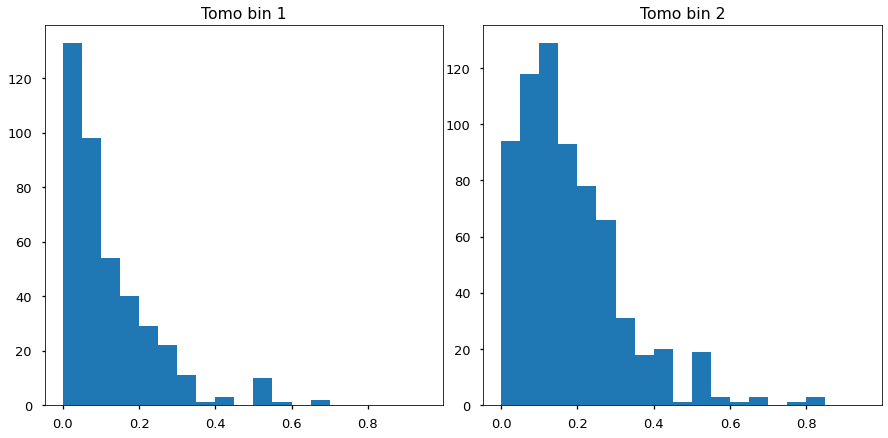

In [247]:
fig, axs = plt.subplots(1,2, figsize = (15, 7))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(1,3):
    cond_bad_redz_pixels = (imbad[i][0] > 0)
    bins_with_bad_redshifts_bad_binning = imbad[i][0][cond_bad_redz_pixels]
    bins_with_bad_redshifts_all_binning = imall[i][0][cond_bad_redz_pixels]
    
    axs[i-1].hist(bins_with_bad_redshifts_bad_binning/bins_with_bad_redshifts_all_binning, bins = np.arange(0, 1, 0.05), cumulative = False, density = False)
    #axs[i-1].set_yscale("log")
    axs[i-1].set_title(f"Tomo bin {i}")

#### Save dndz

In [58]:
bin_ledge = tst_1[1]
bin_mid = bin_ledge[:-1] + np.diff(bin_ledge)/2
bin_ledge = bin_ledge[:-1] #remove the rightmost edge to have same shape as bin_mid

tomo1_values = tst_1[0]
tomo2_values = tst_2[0]

In [59]:
tomograph1 = pd.DataFrame(np.vstack((bin_ledge, bin_mid, tomo1_values)).T, 
                          columns=['Redshift_Ledge', 'Redshift_mid', 'dndz'])
tomograph2 = pd.DataFrame(np.vstack((bin_ledge, bin_mid, tomo2_values)).T, 
                          columns=['Redshift_Ledge', 'Redshift_mid', 'dndz'])

tomograph1.to_csv("../dat/nz_fuji_tomo1.csv", index = False,)
tomograph2.to_csv("../dat/nz_fuji_tomo2.csv", index = False,)

<AxesSubplot:xlabel='Redshift_mid'>

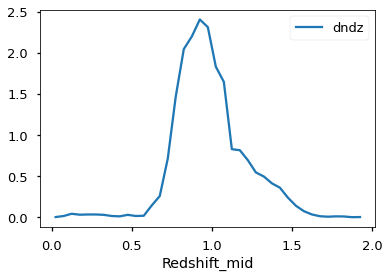

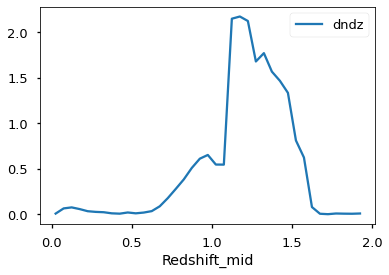

In [60]:
tomograph1.plot('Redshift_mid', 'dndz')
tomograph2.plot('Redshift_mid', 'dndz')

#### Save model

In [62]:
import pickle
# now you can save it to a file
with open('../dat/photoz_RF.pkl', 'wb') as f:
    pickle.dump(clf, f)

/tmp/ipykernel_28146/4038206183.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_specz = X_sampled[indices_test][(y_pred == 1)][:,-1].astype(np.float)


% in tomo bin 1 with bad redshift: 0.046708495169803806


/tmp/ipykernel_28146/4038206183.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_specz = X_sampled[indices_test][(y_pred == 2)][:,-1].astype(np.float)


% in tomo bin 2 with bad redshift: 0.10779808081179455


/tmp/ipykernel_28146/4038206183.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_specz = X_sampled[indices_test][(y_pred != 3) & is_in_circle_test][:,-1].astype(np.float)
/tmp/ipykernel_28146/4038206183.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_specz = X_sampled[indices_test][(y_pred != 3) & (y_pred == 1) & is_in_

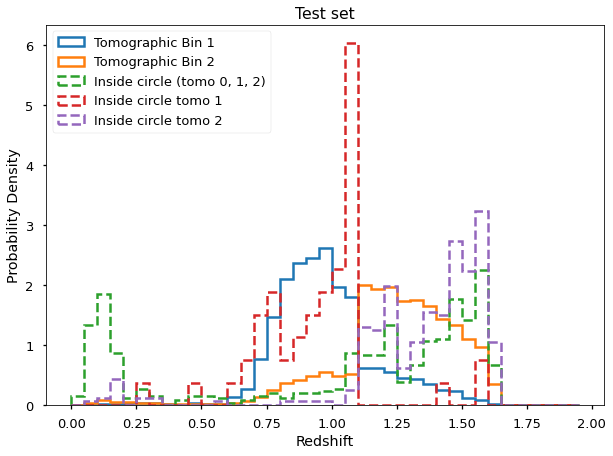

In [272]:
plt.figure(figsize=(10,7))
# tst_1 = plt.hist(X_sampled[indices_test][(y_test == 1)][X_sampled[indices_test][(y_test == 1)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");
# tst_2 = plt.hist(X_sampled[indices_test][(y_test == 2)][X_sampled[indices_test][(y_test == 2)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

zrange = np.arange(0, 2, 0.05)

test_specz = X_sampled[indices_test][(y_pred == 1)][:,-1].astype(np.float)
print(f"% in tomo bin {1} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_1 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");

test_specz = X_sampled[indices_test][(y_pred == 2)][:,-1].astype(np.float)
print(f"% in tomo bin {2} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_2 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

#plot dndz inside the circle
test_specz = X_sampled[indices_test][(y_pred != 3) & is_in_circle_test][:,-1].astype(np.float)
tst_circ = plt.hist(test_specz[test_specz != -99],
                   bins = zrange, density = True, histtype = 'step', lw = 2.5, ls = "dashed", label = 'Inside circle (tomo 0, 1, 2)')

test_specz = X_sampled[indices_test][(y_pred != 3) & (y_pred == 1) & is_in_circle_test][:,-1].astype(np.float)
tst_circ = plt.hist(test_specz[test_specz != -99],
                   bins = zrange, density = True, histtype = 'step', lw = 2.5, ls = "dashed",  label = 'Inside circle tomo 1')

test_specz = X_sampled[indices_test][(y_pred != 3) & (y_pred == 2) & is_in_circle_test][:,-1].astype(np.float)
tst_circ = plt.hist(test_specz[test_specz != -99],
                   bins = zrange, density = True, histtype = 'step', lw = 2.5, ls = "dashed",  label = 'Inside circle tomo 2')


#plt.plot(zrange, cmb_kernel(zrange)/cmb_kernel(zrange).max() * 2, label = 'CMB kernel (Arbitrary Units)', ls = '--', c = 'k')
#plt.yscale("log")
plt.legend(loc = 'upper left')
plt.title("Test set")
plt.xlabel("Redshift")
plt.ylabel("Probability Density")
plt.show()

In [267]:
#cut region
r = .4
h = .15
k = .18
tmpxx, tmpyy = circle_cut(r, h, k)
is_in_circle_df = ((df['r-z'] - h)**2 + (df['g-r'] - k)**2 < r**2)

In [268]:
print(f"% of ELGs removed: {is_in_circle_df.sum()/len(df)}")
print(f"% of bad ELGs inside: {((is_in_circle_df) & (df['label'] == 3)).sum()/len(df[is_in_circle_df])}")
print(f"% of bad ELGs outside: {((~is_in_circle_df) & (df['label'] == 3)).sum()/len(df[~is_in_circle_df])}")

% of ELGs removed: 0.33044291376039053
% of bad ELGs inside: 0.4403030502451384
% of bad ELGs outside: 0.12725419985547137


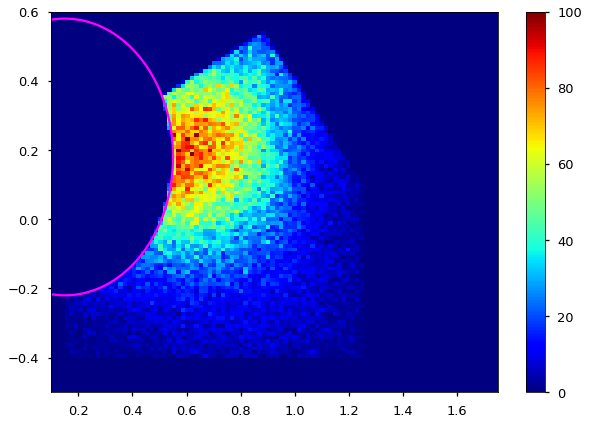

In [269]:
plt.figure(figsize = (10, 7))
i = 2
plt.hist2d(df.loc[(df['label'] == i) & (~is_in_circle_df)]['r-z'], df.loc[(df['label'] == i) & (~is_in_circle_df)]['g-r'], 
           bins = 100, cmap = plt.cm.jet, range = range2d, vmin = 0, vmax = 100);
# plt.hist2d(zcat_elg['r-z'][~is_oii_good], zcat_elg['g-r'][~is_oii_good], 
#             bins = 100, cmap = plt.cm.jet, range = range2d, vmin = 0);
plt.colorbar()
#fdr_plot()
plt.plot(tmpxx, tmpyy, c = 'magenta')

In [270]:
df_remove = df[~is_in_circle_df]

In [271]:
df_remove.head()

,TARGETID,SPECTYPE,SHAPE_R,MAG_G,MAG_R,MAG_Z,g-r,r-z,gfib,rfib,zfib,Z,label
202453,39627884867882965,b'GALAXY',0.596420,22.246650,21.854917,21.212177,0.391733,0.642740,23.103881,22.712148,22.069408,0.835611,1
343099,39633149671508869,b'GALAXY',0.362617,23.515922,23.254010,22.366760,0.261911,0.887250,24.058851,23.796939,22.909689,0.873654,1
166003,39627830652305694,b'GALAXY',0.419995,22.956668,23.268269,22.610416,-0.311602,0.657854,23.573985,23.885586,23.227733,1.269916,2
50416,39632991265230194,b'GALAXY',0.201395,23.360048,23.391629,22.694471,-0.031582,0.697158,23.725712,23.757294,23.060135,0.970413,1
233830,39627805905915946,b'GALAXY',0.270797,23.196672,23.163778,22.515329,0.032893,0.648450,23.633082,23.600188,22.951739,1.198327,2


In [272]:
df_remove.groupby('label').count()#/df.groupby('redz_bin').count()['r-z'].sum()

,TARGETID,SPECTYPE,SHAPE_R,MAG_G,MAG_R,MAG_Z,g-r,r-z,gfib,rfib,zfib,Z
label,,,,,,,,,,,,
0,5570,5570,5570,5570,5570,5570,5570,5570,5570,5570,5570,5570
1,123192,123192,123192,123192,123192,123192,123192,123192,123192,123192,123192,123192
2,86211,86211,86211,86211,86211,86211,86211,86211,86211,86211,86211,86211
3,31345,31345,31345,31345,31345,31345,31345,31345,31345,31345,31345,31345


In [273]:
#split into features and classes
X_remove, y_remove = df_remove.drop(["label"], axis=1), df_remove["label"].values

#scale features
sc = StandardScaler()
X_transformed_remove = sc.fit_transform(X_remove.iloc[:,3:-1])

# Create train/test sets
X_train_remove, X_test_remove, y_train_remove, y_test_remove, indices_train_remove, indices_test_remove = train_test_split(X_transformed_remove, y_remove, np.arange(0, len(X_transformed_remove)), #last element is to track indices
                                                                                 test_size=0.20, shuffle=True,
                                                                                 stratify=y_remove)

In [274]:
#resample training set
per_cat_num_remove = (.80 * np.array([5500, 43000, 86000, 21000])).astype(int) #number of objects to include per category
replace = True

# # Create balanced training / test data set using undersampled majority class records
X_sampled0_remove, y_sampled0_remove = resample(X_train_remove[y_train_remove == 0], y_train_remove[y_train_remove == 0],
                replace=replace,
                n_samples=per_cat_num_remove[0])

X_sampled1_remove, y_sampled1_remove = resample(X_train_remove[y_train_remove == 1], y_train_remove[y_train_remove == 1],
                replace=replace,
                n_samples=per_cat_num_remove[1])

X_sampled2_remove, y_sampled2_remove = resample(X_train_remove[y_train_remove == 2], y_train_remove[y_train_remove == 2],
                replace=replace,
                n_samples=per_cat_num_remove[2])

X_sampled3_remove, y_sampled3_remove = resample(X_train_remove[y_train_remove == 3], y_train_remove[y_train_remove == 3],
                replace=replace,
                n_samples=per_cat_num_remove[3])

#combine
X_balanced_remove = np.vstack((X_sampled0_remove, X_sampled1_remove, X_sampled2_remove, X_sampled3_remove))#, X_sampled4))
y_balanced_remove = np.hstack((y_sampled0_remove, y_sampled1_remove, y_sampled2_remove, y_sampled3_remove))#, y_sampled4))

#shuffle
combined_remove = np.hstack((X_balanced_remove, y_balanced_remove.reshape(-1,1)))
combined_remove = shuffle(combined_remove)

X_balanced_remove = combined_remove[:,0:-1]
y_balanced_remove = combined_remove[:,-1]

In [275]:
for i in range(len(per_cat_num_remove)):
    print(f"Baseline performance: for label {i} is {np.round(per_cat_num_remove[i]/per_cat_num_remove.sum(), 2)}")

Baseline performance: for label 0 is 0.04
Baseline performance: for label 1 is 0.28
Baseline performance: for label 2 is 0.55
Baseline performance: for label 3 is 0.14


In [276]:
np.intersect1d(X_remove.iloc[indices_test_remove]['TARGETID'], X_remove.iloc[indices_train_remove]['TARGETID'])

array([], dtype=int64)

In [277]:
#Create a Gaussian Classifier
clf_remove=RandomForestClassifier(max_depth=70, min_samples_split=5, n_estimators=30)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_remove.fit(X_balanced_remove, y_balanced_remove)

y_pred_remove=clf_remove.predict(X_test_remove)

In [278]:
print("Accuracy:",accuracy_score(y_test_remove, y_pred_remove))
print("Feature importance:",clf_remove.feature_importances_)

Accuracy: 0.4833955829814875
Feature importance: [0.11494184 0.1113791  0.12107101 0.14716933 0.12902706 0.12168796
 0.12005541 0.13466829]


In [279]:
# #cross validation
# from sklearn.model_selection import cross_val_score
# cv_score = cross_val_score(clf, X_train, y_train, cv=5)
# print(cv_score)

In [280]:
tmpxx_scaled, tmpyy_scaled = circle_cut(.7, -2, .05)
is_in_circle_test = ((X_test_remove[:,4] - -2)**2 + (X_test_remove[:,3] - .05)**2 < .45**2)

Text(0.5, 0.98, 'Remove circle')

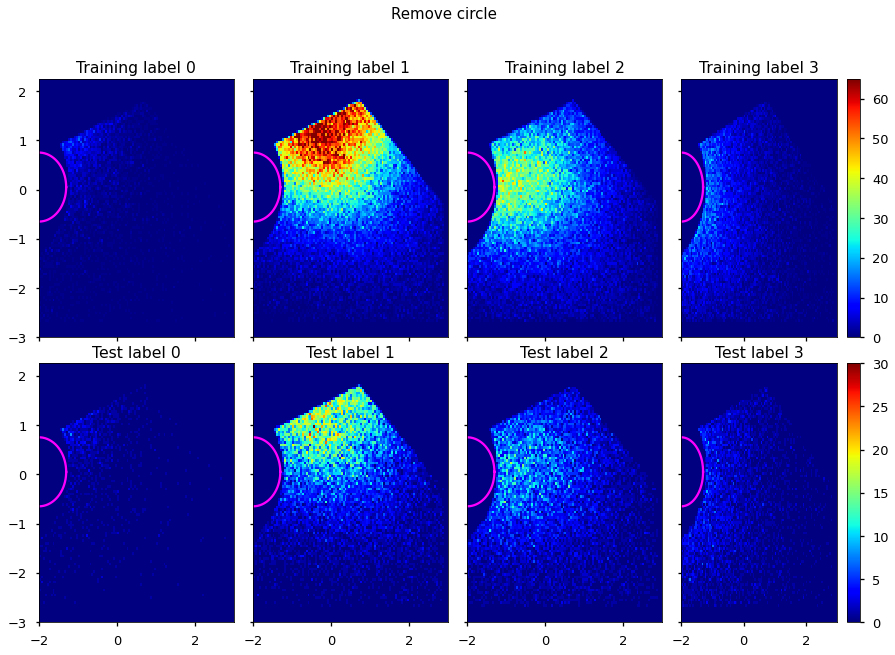

In [281]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize = (15, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(4):
    #training sample
    im0 = axs[0,i].hist2d(X_train_remove[:,4][y_train_remove == i], X_train_remove[:,3][y_train_remove == i], 
                    bins = 100, cmap = plt.cm.jet, vmin = vmin, vmax = 65, range = [[-2, 3], [-3, 2.25]]);
    axs[0,i].plot(tmpxx_scaled, tmpyy_scaled, c = 'magenta')
    axs[0,i].set_title(f"Training label {i}")
    
    #test sample
    im1 = axs[1,i].hist2d(X_test_remove[:,4][y_test_remove == i], X_test_remove[:,3][y_test_remove == i], 
                    bins = 100, cmap = plt.cm.jet, vmin = vmin, vmax = 30, range = [[-2, 3], [-3, 2.25]]);
    axs[1,i].set_title(f"Test label {i}")
    axs[1,i].plot(tmpxx_scaled, tmpyy_scaled, c = 'magenta')

    #add common colorbar
cbar1 = fig.colorbar(im0[3], ax=axs[0][3])
cbar2 = fig.colorbar(im1[3], ax=axs[1][3])

# hide tick and tick label of the big axis
fig.suptitle("Remove circle", fontsize = 15)
# fig.supxlabel('r-z', fontsize = 15)
# fig.supylabel('g-r', fontsize = 15)

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Remove circle')

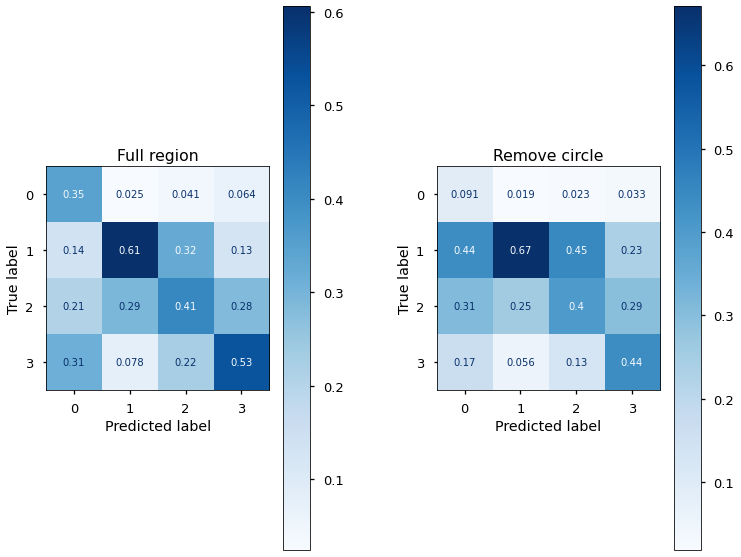

In [282]:
fig, axs = plt.subplots(1, 2, figsize = (12, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

plot_confusion_matrix(clf, X_test, y_test, normalize='pred', cmap=plt.cm.Blues, ax=axs[0])
axs[0].set_title("Full region")
plot_confusion_matrix(clf_remove, X_test_remove, y_test_remove, normalize='pred', cmap=plt.cm.Blues, ax=axs[1])
axs[1].set_title("Remove circle")

In [ ]:
plt.figure(figsize=(10,7))
zrange = np.arange(0, 2, 0.05)

test_specz = X_remove.iloc[indices_test_remove][y_pred_remove == 1]['Z']
print(f"% in tomo bin {1} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_1 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");

test_specz = X_remove.iloc[indices_test_remove][y_pred_remove == 2]['Z']
print(f"% in tomo bin {2} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_2 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

plt.plot(zrange, cmb_kernel(zrange)/cmb_kernel(zrange).max() * 2, label = 'CMB kernel (Arbitrary Units)', ls = '--', c = 'k')
#plt.yscale("log")
plt.legend(loc = 'upper left')
plt.title("Photometric Redshift Distribution - circle removed")
plt.xlabel("Redshift")
plt.ylabel("Probability Density")
plt.show()
#plt.savefig("../plots/tomo_dndz.pdf", bbox_inches = 'tight', dpi = 450)

% in tomo bin 1 with bad redshift: 0.05642036571273197
% in tomo bin 2 with bad redshift: 0.12653681894655106


In [181]:
for i in range (1,3):
    tmp_spectype = X_sampled_remove[indices_test_remove][(y_pred_remove == i)]
    bad_redshift_cond = tmp_spectype[:,-1].astype(np.float) == -99 
    for stype in ['GALAXY', 'STAR', 'QSO']:
        #print("# of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {(tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()}")
        print("% of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {np.round((tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()/len(tmp_spectype[bad_redshift_cond]) * 100,2)}")
        #print("% overall of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {np.round((tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()/len(tmp_spectype) * 100,2)}")

/tmp/ipykernel_28146/883675222.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bad_redshift_cond = tmp_spectype[:,-1].astype(np.float) == -99


% of bad redshifts belonging to SPECTYPE GALAXY in tomo bin 1 is 70.83
% of bad redshifts belonging to SPECTYPE STAR in tomo bin 1 is 1.89
% of bad redshifts belonging to SPECTYPE QSO in tomo bin 1 is 27.27
% of bad redshifts belonging to SPECTYPE GALAXY in tomo bin 2 is 88.47
% of bad redshifts belonging to SPECTYPE STAR in tomo bin 2 is 0.2
% of bad redshifts belonging to SPECTYPE QSO in tomo bin 2 is 11.33


/tmp/ipykernel_28146/327605384.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_specz = X_sampled_remove[indices_test_remove][(y_pred_remove == 1)][:,-1].astype(np.float)


% in tomo bin 1 with bad redshift: 0.04717936498480967


/tmp/ipykernel_28146/327605384.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_specz = X_sampled_remove[indices_test_remove][(y_pred_remove == 2)][:,-1].astype(np.float)


% in tomo bin 2 with bad redshift: 0.08742671009771986


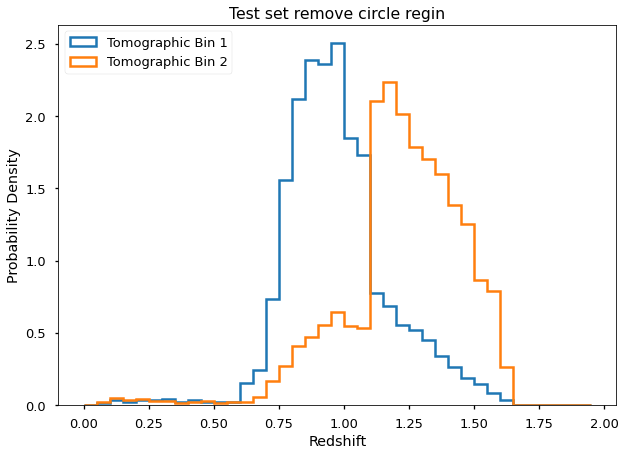

In [182]:
plt.figure(figsize=(10,7))
# tst_1 = plt.hist(X_sampled[indices_test][(y_test == 1)][X_sampled[indices_test][(y_test == 1)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");
# tst_2 = plt.hist(X_sampled[indices_test][(y_test == 2)][X_sampled[indices_test][(y_test == 2)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

zrange = np.arange(0, 2, 0.05)

test_specz = X_sampled_remove[indices_test_remove][(y_pred_remove == 1)][:,-1].astype(np.float)
print(f"% in tomo bin {1} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_1 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");

test_specz = X_sampled_remove[indices_test_remove][(y_pred_remove == 2)][:,-1].astype(np.float)
print(f"% in tomo bin {2} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_2 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

#plt.plot(zrange, cmb_kernel(zrange)/cmb_kernel(zrange).max() * 2, label = 'CMB kernel (Arbitrary Units)', ls = '--', c = 'k')
#plt.yscale("log")
plt.legend(loc = 'upper left')
plt.title("Test set remove circle regin")
plt.xlabel("Redshift")
plt.ylabel("Probability Density")
plt.show()

In [ ]:
tmp_spectype = X_sampled_remove[indices_test_remove][(y_pred_remove == 1)]
bad_redshift_cond = (tmp_spectype[:,-1].astype(np.float) == -99)

In [185]:
tmp_spectype[bad_redshift_cond]

array([['0.4487882538970531', '0.11076165053066234',
        '23.643226561322805', ..., '39627794329636499', 'GALAXY',
        '-99.0'],
       ['0.6399097522279362', '0.03004563609142963',
        '23.790178498856253', ..., '39627763581190378', 'GALAXY',
        '-99.0'],
       ['0.3772651105485316', '-0.040251042888421296',
        '23.62046919899541', ..., '39633158328549842', 'GALAXY', '-99.0'],
       ...,
       ['0.6940713099318465', '0.28880161243674607',
        '23.704389163508928', ..., '39627769604213664', 'GALAXY',
        '-99.0'],
       ['0.8362046945127588', '-0.009394474600021852',
        '23.383131280147442', ..., '39632941734693315', 'GALAXY',
        '-99.0'],
       ['0.39200302524917063', '-0.18006552994642888',
        '23.186591222445326', ..., '39633127676575863', 'GALAXY',
        '-99.0']], dtype=object)

/tmp/ipykernel_28146/2219817557.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bad_redshift_cond = (tmp_spectype[:,-1].astype(np.float) == -99)
/tmp/ipykernel_28146/2219817557.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im0 = axs[i-1].hist2d(tmp_spectype[bad_redshift_cond][:,0].astype(np.float), tmp_spectype[bad_redshift_cond

Text(0.5, 0.98, 'Distribution of bad redshifts per tomographic bin')

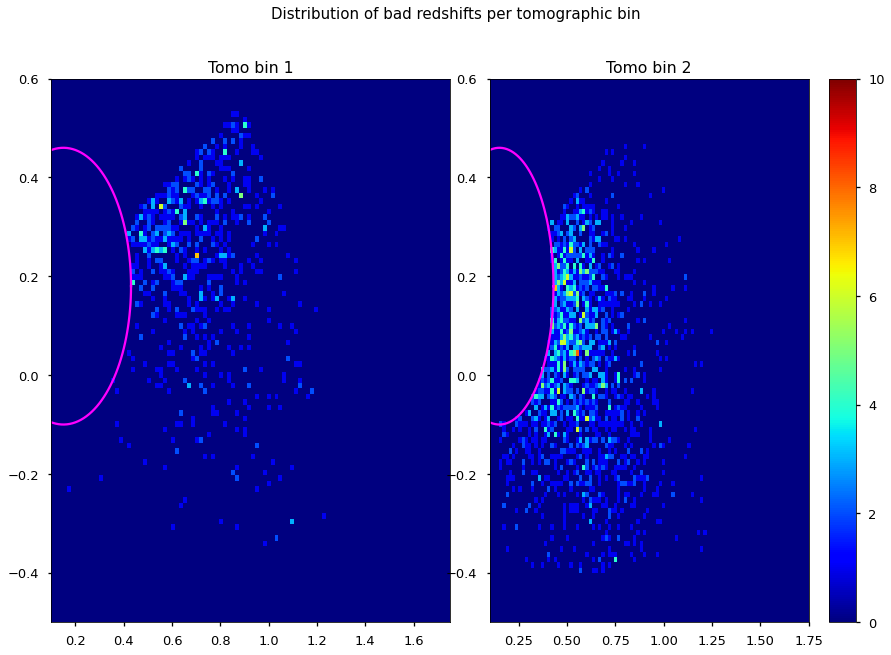

In [194]:
fig, axs = plt.subplots(1,2, figsize = (15, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(1,3):
    tmp_spectype = X_sampled_remove[indices_test_remove][(y_pred_remove == i)]
    bad_redshift_cond = (tmp_spectype[:,-1].astype(np.float) == -99)
    
    #histogram
    im0 = axs[i-1].hist2d(tmp_spectype[bad_redshift_cond][:,0].astype(np.float), tmp_spectype[bad_redshift_cond][:,1].astype(np.float), 
                    bins = 100, cmap = plt.cm.jet, vmin = vmin, vmax = 10, range = range2d);
    axs[i-1].plot(tmpxx, tmpyy, c = 'magenta')
    axs[i-1].set_title(f"Tomo bin {i}")
        
#add common colorbar
cbar1 = fig.colorbar(im0[3], ax=axs[1])
# cbar2 = fig.colorbar(im1[3], ax=axs[1][3])

# hide tick and tick label of the big axis
fig.suptitle("Distribution of bad redshifts per tomographic bin", fontsize = 15)
# # fig.supxlabel('r-z', fontsize = 15)
# fig.supylabel('g-r', fontsize = 15)

In [184]:
for i in range (1,3):
    tmp_spectype = X_sampled_remove[indices_test_remove][(y_pred_remove == i)]
    bad_redshift_cond = tmp_spectype[:,-1].astype(np.float) == -99 
    for stype in ['GALAXY', 'STAR', 'QSO']:
        #print("# of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {(tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()}")
        print("% of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {np.round((tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()/len(tmp_spectype[bad_redshift_cond]) * 100,2)}")
        #print("% overall of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {np.round((tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()/len(tmp_spectype) * 100,2)}")

array([['0.4487882538970531', '0.11076165053066234',
        '23.643226561322805', ..., '39627794329636499', 'GALAXY',
        '-99.0'],
       ['0.6399097522279362', '0.03004563609142963',
        '23.790178498856253', ..., '39627763581190378', 'GALAXY',
        '-99.0'],
       ['0.3772651105485316', '-0.040251042888421296',
        '23.62046919899541', ..., '39633158328549842', 'GALAXY', '-99.0'],
       ...,
       ['0.6940713099318465', '0.28880161243674607',
        '23.704389163508928', ..., '39627769604213664', 'GALAXY',
        '-99.0'],
       ['0.8362046945127588', '-0.009394474600021852',
        '23.383131280147442', ..., '39632941734693315', 'GALAXY',
        '-99.0'],
       ['0.39200302524917063', '-0.18006552994642888',
        '23.186591222445326', ..., '39633127676575863', 'GALAXY',
        '-99.0']], dtype=object)

Text(0.5, 0.98, '(y_test == 3) & (y_pred != 3)')

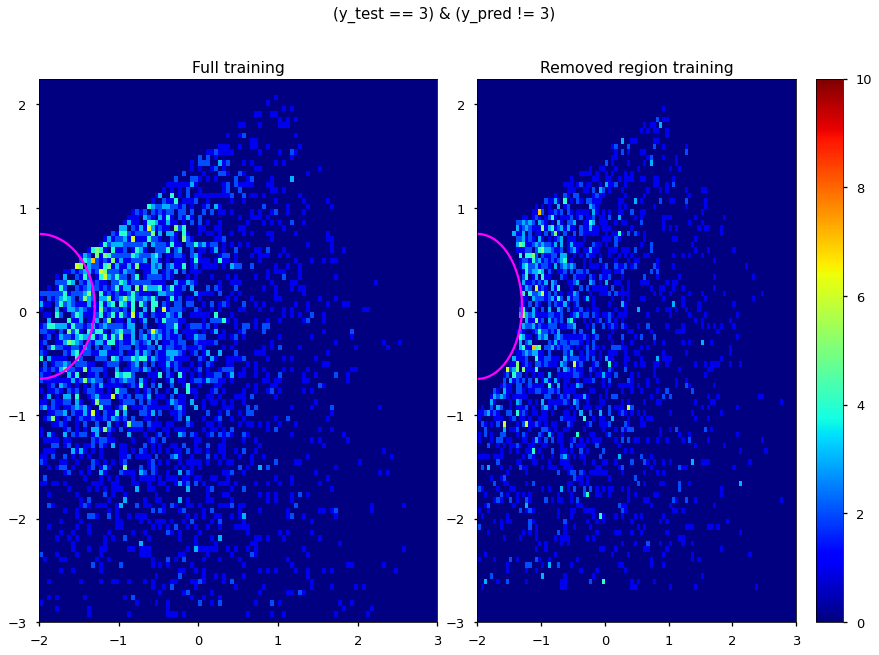

In [614]:
fig, axs = plt.subplots(1,2, figsize = (15, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

#full region
im0 = axs[0].hist2d(X_test[:,0][(y_test == 3) & (y_pred != 3)], X_test[:,1][(y_test == 3) & (y_pred != 3)], 
                    bins = 100, cmap = plt.cm.jet, vmin = vmin, vmax = 10, range = [[-2, 3], [-3, 2.25]]);
axs[0].plot(tmpxx_scaled, tmpyy_scaled, c = 'magenta')
axs[0].set_title(f"Full training")
    
    
im0 = axs[1].hist2d(X_test_remove[:,0][(y_test_remove == 3) & (y_pred_remove != 3)], X_test_remove[:,1][(y_test_remove == 3) & (y_pred_remove != 3)], 
                    bins = 100, cmap = plt.cm.jet, vmin = vmin, vmax = 10, range = [[-2, 3], [-3, 2.25]]);
axs[1].plot(tmpxx_scaled, tmpyy_scaled, c = 'magenta')
axs[1].set_title(f"Removed region training")
    
#add common colorbar
cbar1 = fig.colorbar(im0[3], ax=axs[1])
# cbar2 = fig.colorbar(im1[3], ax=axs[1][3])

# hide tick and tick label of the big axis
fig.suptitle("(y_test == 3) & (y_pred != 3)", fontsize = 15)
# # fig.supxlabel('r-z', fontsize = 15)
# fig.supylabel('g-r', fontsize = 15)

Text(0.5, 0.98, '(y_test != 3) & (y_pred == 3)')

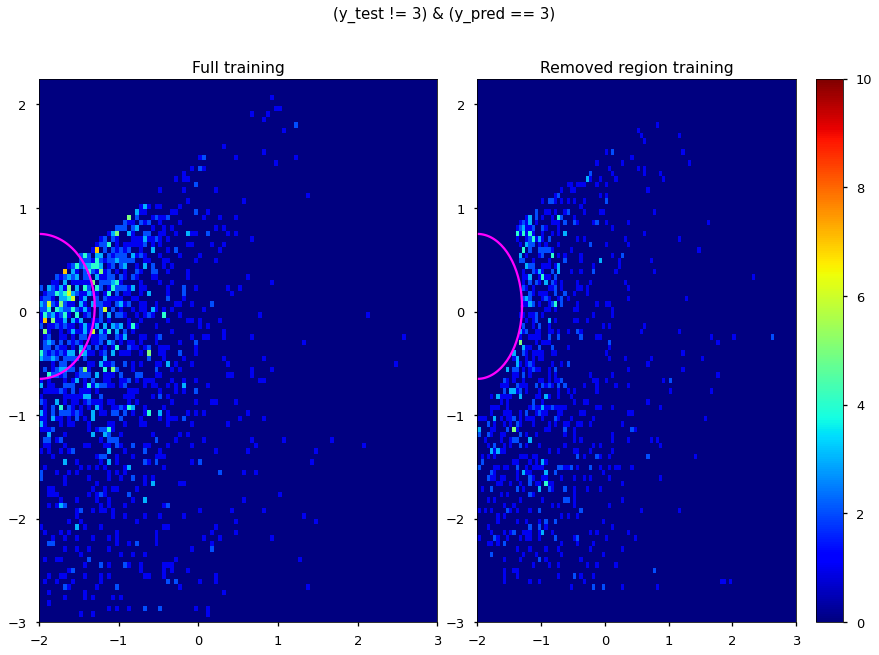

In [615]:
fig, axs = plt.subplots(1,2, figsize = (15, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

#full region
im0 = axs[0].hist2d(X_test[:,0][(y_test != 3) & (y_pred == 3)], X_test[:,1][(y_test != 3) & (y_pred == 3)], 
                    bins = 100, cmap = plt.cm.jet, vmin = vmin, vmax = 10, range = [[-2, 3], [-3, 2.25]]);
axs[0].plot(tmpxx_scaled, tmpyy_scaled, c = 'magenta')
axs[0].set_title(f"Full training")
    
    
im0 = axs[1].hist2d(X_test_remove[:,0][(y_test_remove != 3) & (y_pred_remove == 3)], X_test_remove[:,1][(y_test_remove != 3) & (y_pred_remove == 3)], 
                    bins = 100, cmap = plt.cm.jet, vmin = vmin, vmax = 10, range = [[-2, 3], [-3, 2.25]]);
axs[1].plot(tmpxx_scaled, tmpyy_scaled, c = 'magenta')
axs[1].set_title(f"Removed region training")
    
#add common colorbar
cbar1 = fig.colorbar(im0[3], ax=axs[1])
# cbar2 = fig.colorbar(im1[3], ax=axs[1][3])

# hide tick and tick label of the big axis
fig.suptitle("(y_test != 3) & (y_pred == 3)", fontsize = 15)
# # fig.supxlabel('r-z', fontsize = 15)
# fig.supylabel('g-r', fontsize = 15)

In [299]:
#make bins
pivot = 1.2
lowz_interloper_bin = zcat_elg['Z'] < 0.6
tomo_1_bin = (zcat_elg['Z'] > 0.6) & (zcat_elg['Z'] < pivot)
tomo_2_bin = (zcat_elg['Z'] >= pivot) & (zcat_elg['Z'] <= 1.65)
misc_bad_bin = (~is_spectype) | is_bad_flux | (~(is_oii_good.filled(False))) #either spectype does not match GALAXY, flux is missing or negative or does not meet Anand's cut

#bin categories; 0 = lowz, 1 = 1st tomo bin, 2 = 2nd tomo bin, 3 = highz
bin_cat = -99 * np.ones(len(zcat_elg))

#the ordering is important because ELGs in misc bad bin have redshift so if misc_bad_bin is not executed first, assignment of label bins will be wrong. Order of importance: misc_bad_bin, lowz, tomo1, tomo2
for i in range(len(zcat_elg)):
    if(misc_bad_bin[i]):
        bin_cat[i] = 3
    elif(lowz_interloper_bin[i]):
        bin_cat[i] = 0
    elif(tomo_1_bin[i]):
        bin_cat[i] = 1
    elif(tomo_2_bin[i]):
        bin_cat[i] = 2

In [300]:
for i in range(4):
    print(f"% of ELGs in bin {i} is: {(bin_cat == i).sum()/len(bin_cat)}")

% of ELGs in bin 0 is: 0.043489272219820366
% of ELGs in bin 1 is: 0.4610400075722498
% of ELGs in bin 2 is: 0.25103287021522075
% of ELGs in bin 3 is: 0.24443784999270915


In [301]:
zcat_elg['bin_label'] = bin_cat.astype(int)

In [302]:
cond = is_not_incomplete & (~misc_bad_bin)
cond_bad = is_not_incomplete & misc_bad_bin

print(f"good: {cond.sum()}")
print(f"total: {len(cond)}")
print(f"bad: {(~cond).sum()} and %: {(~cond).sum()/len(cond)}")

good: 286664
total: 390901
bad: 104237 and %: 0.26665830990455386


In [303]:
mag_dict = {}
mag_dict['g'] = np.concatenate((zcat_elg['MAG_G'][cond], zcat_elg['MAG_G'][cond_bad])) #combine both ZWARN == 0 and != 0
mag_dict['r'] = np.concatenate((zcat_elg['MAG_R'][cond], zcat_elg['MAG_R'][cond_bad]))
mag_dict['z'] = np.concatenate((zcat_elg['MAG_Z'][cond], zcat_elg['MAG_Z'][cond_bad]))
mag_dict['gr'] = np.concatenate((zcat_elg['g-r'][cond], zcat_elg['g-r'][cond_bad]))
mag_dict['rz'] = np.concatenate((zcat_elg['r-z'][cond], zcat_elg['r-z'][cond_bad]))
mag_dict['shape_r'] = np.concatenate((zcat_elg['SHAPE_R'][cond], zcat_elg['SHAPE_R'][cond_bad]))
mag_dict['TARGETID'] = np.concatenate((zcat_elg['TARGETID'][cond], zcat_elg['TARGETID'][cond_bad]))
mag_dict['SPECTYPE'] = np.concatenate((zcat_elg['SPECTYPE'][cond], zcat_elg['SPECTYPE'][cond_bad]))
mag_dict['specz'] = np.concatenate((np.array(zcat_elg['Z'][cond]), -99*np.ones_like(zcat_elg['Z'][cond_bad])))
mag_dict['label'] = np.concatenate((bin_cat[cond], bin_cat[cond_bad]))

data_array = np.array([mag_dict['rz'], mag_dict['gr'], mag_dict['g'], mag_dict['r'],
                       mag_dict['z'], mag_dict['shape_r'], mag_dict['TARGETID'], mag_dict['SPECTYPE'].astype(str), mag_dict['specz'], mag_dict['label'].astype(int)])
df = pd.DataFrame(data_array.T, columns = ['r-z','g-r', 'g', 'r', 'z', 'shape_r', 'targetid', 'spectype',
                                           'specz', 'redz_bin'])

df = df.sample(frac=1)

print(df)

                       r-z                   g-r                   g  \
360393  0.2815537137167716   0.16659458137425176   23.24214481828513   
333072  0.2463514200100576   0.14394697768425146  22.892897983025676   
8101     1.132787402120801  0.024521480809237772  23.646958373087834   
147298  0.6747830108460171    0.3648150068171354   23.39062584931873   
128522  0.9433385345494756    0.2480439727543775  23.405664983792665   
...                    ...                   ...                 ...   
79370   0.7094994378656416    0.3353157888071614   22.29391066816531   
258157  0.3531286816668491   0.25006740114995907   23.28153595641588   
138715  0.9073101775606567   0.24371388785682768   23.72092346027408   
123087  0.9377786540971869    0.3264446185609984   22.35222462869833   
303155  0.4331041638264317    0.1279273131280938   22.00658828637045   

                         r                   z     shape_r           targetid  \
360393   23.07555023691088  22.793996523194107  0.3802

In [304]:
df.groupby('redz_bin').count()#/df.groupby('redz_bin').count()['r-z'].sum()

,r-z,g-r,g,r,z,shape_r,targetid,spectype,specz
redz_bin,,,,,,,,,
0,16312,16312,16312,16312,16312,16312,16312,16312,16312
1,176140,176140,176140,176140,176140,176140,176140,176140,176140
2,94212,94212,94212,94212,94212,94212,94212,94212,94212
3,89852,89852,89852,89852,89852,89852,89852,89852,89852


In [305]:
replace = True
#split into features and classes
#X, y = df.drop(["redz_bin", "g", "r", "z"], axis=1), df["redz_bin"].values.flatten()
#X, y = df.drop(["redz_bin", "g", "r", "z"], axis=1), df["redz_bin"].values.flatten()
X, y = df.drop(["redz_bin"], axis=1), df["redz_bin"].astype(int).values.flatten()

per_cat_num =np.array([10000, 56000, 94000, 28000]) #number of objects to include per category

# Create balanced training / test data set using undersampled majority class records
X_sampled0, y_sampled0 = resample(X[y == 0], y[y == 0],
                replace=replace,
                n_samples=per_cat_num[0])

X_sampled1, y_sampled1 = resample(X[y == 1], y[y == 1],
                replace=replace,
                n_samples=per_cat_num[1])

X_sampled2, y_sampled2 = resample(X[y == 2], y[y == 2],
                replace=replace,
                n_samples=per_cat_num[2])

X_sampled3, y_sampled3 = resample(X[y == 3], y[y == 3],
                replace=replace,
                n_samples=per_cat_num[3])

# X_sampled4, y_sampled4 = resample(X[y == 4], y[y == 4],
#                 replace=replace,
#                 n_samples=per_cat_num[4])

#combine
X_sampled_pivot = np.vstack((X_sampled0, X_sampled1, X_sampled2, X_sampled3))#, X_sampled4))
y_balanced_pivot = np.hstack((y_sampled0, y_sampled1, y_sampled2, y_sampled3))#, y_sampled4))

#scale features
sc = StandardScaler()
X_balanced_pivot = sc.fit_transform(X_sampled_pivot[:, [0, 1, 2, 3, 4, 5]]) #drop the specz column for training, but keep it in X_sampled for plotting dndz

# Create train/test sets
X_train_pivot, X_test_pivot, y_train_pivot, y_test_pivot, indices_train_pivot,indices_test_pivot = train_test_split(X_balanced_pivot, y_balanced_pivot,
                                      np.arange(0, len(X_balanced_pivot)),
                                      test_size=0.20, stratify=None)

In [306]:
for i in range(len(per_cat_num)):
    print(f"Baseline performance: for label {i} is {np.round(per_cat_num[i]/per_cat_num.sum(), 2)}")

Baseline performance: for label 0 is 0.05
Baseline performance: for label 1 is 0.3
Baseline performance: for label 2 is 0.5
Baseline performance: for label 3 is 0.15


In [307]:
#Create a Gaussian Classifier
clf_pivot=RandomForestClassifier(n_estimators=30)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_pivot.fit(X_train_pivot,y_train_pivot)

y_pred_pivot=clf_pivot.predict(X_test_pivot)

print("Accuracy:",accuracy_score(y_test_pivot, y_pred_pivot))
print("Feature importance:",clf_pivot.feature_importances_)

Accuracy: 0.7000531914893617
Feature importance: [0.20858817 0.18564445 0.16103518 0.15594716 0.16966702 0.11911802]


/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


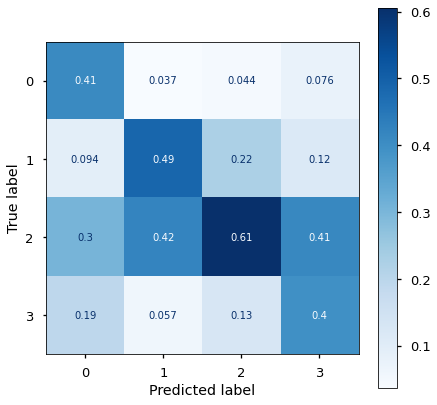

In [308]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(clf, X_test_pivot, y_test_pivot, normalize='pred', cmap=plt.cm.Blues, ax=ax)
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
# tst_1 = plt.hist(X_sampled[indices_test][(y_test == 1)][X_sampled[indices_test][(y_test == 1)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");
# tst_2 = plt.hist(X_sampled[indices_test][(y_test == 2)][X_sampled[indices_test][(y_test == 2)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

zrange = np.arange(0, 2, 0.05)

test_specz = X_sampled_pivot[indices_test_pivot][(y_pred_pivot == 1)][:,-1].astype(np.float)
print(f"% in tomo bin {1} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_1 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");

test_specz = X_sampled_pivot[indices_test_pivot][(y_pred_pivot == 2)][:,-1].astype(np.float)
print(f"% in tomo bin {2} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_2 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

#plt.plot(zrange, cmb_kernel(zrange)/cmb_kernel(zrange).max() * 2, label = 'CMB kernel (Arbitrary Units)', ls = '--', c = 'k')
#plt.yscale("log")
plt.legend(loc = 'upper left')
plt.title(r"Test set, $z_{\rm pivot} = 1.2$")
plt.xlabel("Redshift")
plt.ylabel("Probability Density")
plt.show()

/tmp/ipykernel_28146/11483884.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_specz = X_sampled_pivot[indices_test_pivot][(y_pred_pivot == 1)][:,-1].astype(np.float)


% in tomo bin 1 with bad redshift: 0.05230335948501308


### Add exponential decay to the curve

In [175]:
# define decay constant function 
decay_const = lambda P0, area : P0/area

# define exponential decay; zr is the rightmost bin defined in the actual hist
tail_pz = lambda P0, area, z, zr : P0*np.exp(-(P0/area)*(z - zr))

In [176]:
#specify extended range

zrange_hist = tst_2[1][:-1] + np.diff(tst_2[1])/2 #actual histogram bin centers 
zextend_max = 3 #max redshift we will estimate out to 
zrange_extend = np.arange(zrange_hist[-1], zextend_max, 0.1) #maintain same binning width
zrange_comb = np.concatenate((zrange_hist, zrange_extend)) # full redshift bin center range 

def extended_pz(bad_percnt, dndz_curve):
    m = bad_percnt
    r = np.random.default_rng(20221109).uniform(0, m)
    normed_curve = dndz_curve * (1 - r)
    
    tail_curve = tail_pz(normed_curve[-1], r, zrange_extend, zrange_hist[-1])
    pz_comb = np.concatenate((normed_curve, tail_curve))
    
    return pz_comb

In [177]:
print(zrange_comb)
pz_dist_extended = extended_pz(len(test_specz[test_specz == -99])/len(test_specz), tst_2[0]) 

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 1.15 1.25 1.35
 1.45 1.55 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65
 2.75 2.85 2.95]


In [181]:
# delete the same element appearing twice 
zrange_comb = np.delete(zrange_comb, 15) #15th and 16th elements are the same
pz_dist_extended = np.delete(pz_dist_extended, 15)

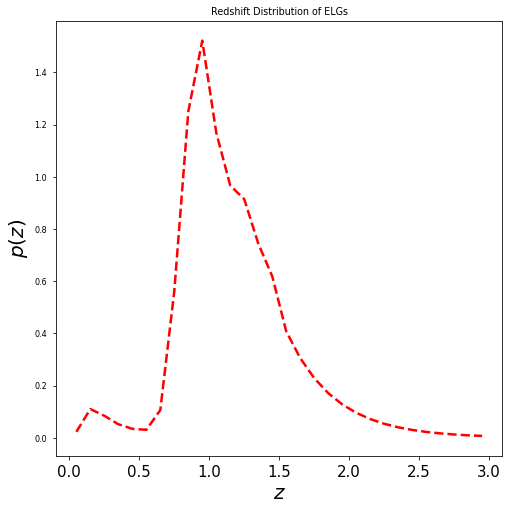

In [185]:
plt.figure(figsize=(8,8))
#for ii in range(1000):
#    plt.plot(zrange_comb, dndz_curves_extended[ii], alpha = 0.1, c = 'k', lw = 1)
plt.plot(zrange_comb, pz_dist_extended, alpha = 1, lw = 2.5, c = 'r', ls = '--')
plt.xlabel(r"$z$", fontsize = 20)
plt.ylabel(r"$p(z)$", fontsize = 20)
plt.savefig("../figures/dndz_main.pdf", bbox_inches = 'tight', dpi = 300)
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.title("Redshift Distribution of ELGs")
plt.show()

Save redshift distribution for theory calculations.

In [189]:
tmpd = {'Redshift_mid' : tst_2[1][:-1] + np.diff(tst_2[1])/2,
    'pz' : tst_2[0]} #dn/(dz * ddeg2)
pzdz = pd.DataFrame(tmpd)
pzdz.to_csv("../finalproducts/fuji_pz_single_tomo.csv")

## Redshift Uncertainty Distribution Estimation

In [2]:
dndz_curves = np.zeros((1000, 16))
bad_percnt = np.zeros(1000)

In [3]:
count = 0
for h in range(10):
    #tmparr = np.load("/pscratch/sd/t/tanveerk/photo-z/" + str(h) + "_normed.npy", allow_pickle=True)
    tmparr = np.load("/global/cscratch1/sd/tanveerk/perlmutter_backup/photo-z/" + str(h) +
                     "_normed.npy", allow_pickle=True) #for cori
    for i in range(10):
        for j in range(10):
            idx = h * 100 + i * 10 + j                
            #print(idx)
            dndz_curves[idx] = tmparr[i][j][0]
            bad_percnt[idx] = tmparr[i][j][2]
            count += 1

### Distribution of percentage of ELGs without redshift

(array([ 4.,  7.,  7., 23., 36., 68., 74., 88., 97., 88., 80., 88., 76.,
        63., 52., 38., 33., 20., 17., 12., 12.,  4.,  7.,  2.,  4.]),
 array([0.12646742, 0.12964033, 0.13281323, 0.13598614, 0.13915904,
        0.14233195, 0.14550485, 0.14867776, 0.15185066, 0.15502357,
        0.15819647, 0.16136938, 0.16454228, 0.16771519, 0.17088809,
        0.174061  , 0.1772339 , 0.18040681, 0.18357972, 0.18675262,
        0.18992553, 0.19309843, 0.19627134, 0.19944424, 0.20261715,
        0.20579005]),
 <BarContainer object of 25 artists>)

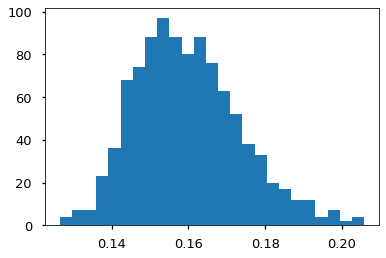

In [112]:
plt.hist(bad_percnt, bins = 25)

### Plot dndz curves and baseline curve

In [116]:
tst_2[1]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5])

In [115]:
tmparr[0][0][1]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6])

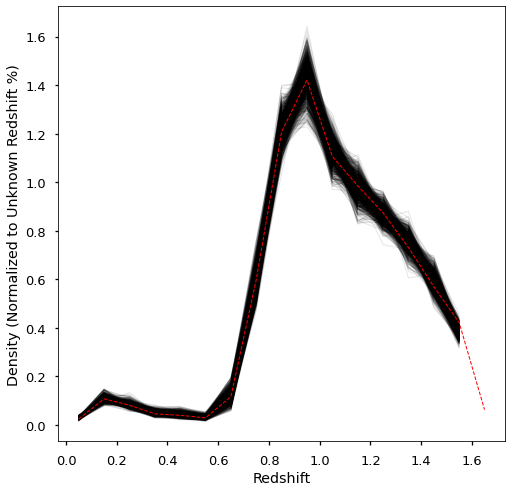

In [45]:
plt.figure(figsize=(8,8))
for ii in range(1000):
    plt.plot(tst_2[1][:-2] + np.diff(tst_2[1][:-1])/2, dndz_curves[ii] * (1 - bad_percnt[ii]), alpha = 0.1, c = 'k', lw = 1)
plt.plot(tst_2[1][:-1] + np.diff(tst_2[1])/2, tst_2[0] * (1 - (test_specz == -99).sum()/len(test_specz)), alpha = 1, lw = 1, c = 'r', ls = '--')
plt.xlabel("Redshift")
plt.ylabel("Density (Normalized to Unknown Redshift %)")
plt.show()

Calculate photo-z covariance

In [46]:
cov = np.cov(dndz_curves.T)
err = np.std(dndz_curves.T, axis = 1, ddof = 1)
corr = cov/np.outer(err, err)

zranges = tst_2[1][:-1] + np.diff(tst_2[1])/2

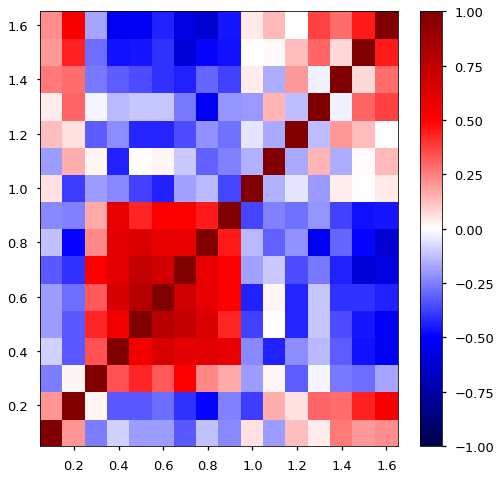

In [47]:
plt.figure(figsize=(8, 8))
plt.pcolor(zranges, zranges, corr, vmin = -1, vmax = +1, cmap = 'seismic')
plt.colorbar()

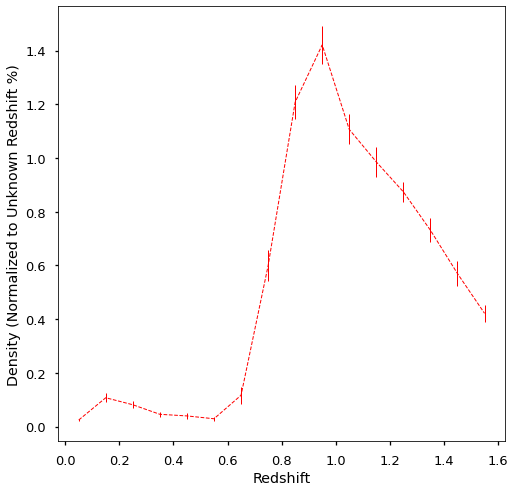

In [49]:
plt.figure(figsize=(8,8))
# for ii in range(1000):
#     plt.plot(tst_2[1][:-1] + np.diff(tst_2[1])/2, dndz_curves[ii] * (1 - bad_percnt[ii]), alpha = 0.1, c = 'k', lw = 1)
plt.errorbar(tst_2[1][:-2] + np.diff(tst_2[1][:-1])/2, tst_2[0][:-1] * (1 - (test_specz == -99).sum()/len(test_specz)), yerr = err, alpha = 1, lw = 1, c = 'r', ls = '--')
plt.xlabel("Redshift")
plt.ylabel("Density (Normalized to Unknown Redshift %)")
plt.show()

Signal-to-noise per redshift bin

In [162]:
yval = tst_2[0] * (1 - (test_specz == -99).sum()/len(test_specz))

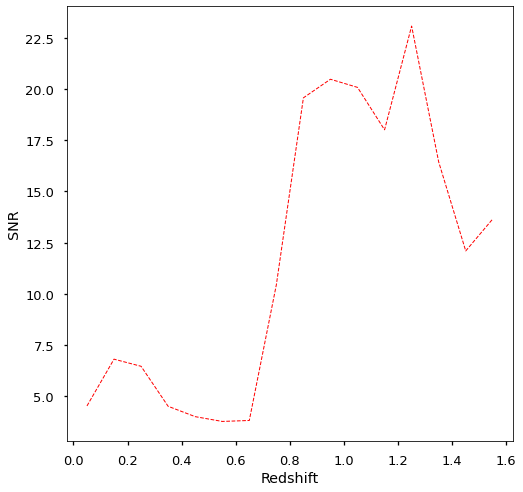

In [163]:
plt.figure(figsize=(8,8))
# for ii in range(1000):
#     plt.plot(tst_2[1][:-1] + np.diff(tst_2[1])/2, dndz_curves[ii] * (1 - bad_percnt[ii]), alpha = 0.1, c = 'k', lw = 1)
plt.plot(tst_2[1][:-1] + np.diff(tst_2[1])/2, yval/err, alpha = 1, lw = 1, c = 'r', ls = '--')
plt.xlabel("Redshift")
plt.ylabel("SNR")
plt.show()

#### Add exponential decay to curve

In [4]:
# define decay constant function 
decay_const = lambda P0, area : P0/area

# define exponential decay; zr is the rightmost bin defined in the actual hist
tail_pz = lambda P0, area, z, zr : P0*np.exp(-(P0/area)*(z - zr))

In [7]:
zrange_hist = tmparr[0][0][1][:-1] + np.diff(tmparr[0][0][1])/2 #actual histogram bin centers 
zextend_max = 3 #max redshift we will estimate out to 
zrange_extend = np.arange(zrange_hist[-1], zextend_max, 0.1) #maintain same binning width
zrange_comb = np.concatenate((zrange_hist, zrange_extend)) # full redshift bin center range 

def extended_pz(idx):
    m = bad_percnt[idx]
    r = np.random.default_rng(20220901).uniform(0, m)
    normed_curve = dndz_curves[idx] * (1 - r)
    
    tail_curve = tail_pz(normed_curve[-1], r, zrange_extend, zrange_hist[-1])
    pz_comb = np.concatenate((normed_curve, tail_curve))
    
    return pz_comb

In [8]:
dndz_curves_extended = np.zeros((len(dndz_curves), len(zrange_comb)))

for jj in range(len(dndz_curves)):
    dndz_curves_extended[jj] = extended_pz(jj)

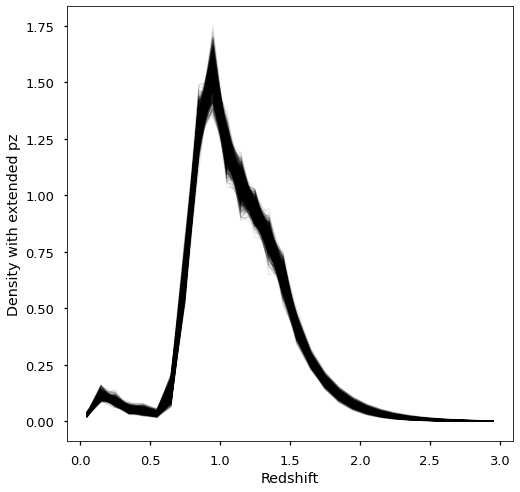

In [10]:
plt.figure(figsize=(8,8))
for ii in range(1000):
    plt.plot(zrange_comb, dndz_curves_extended[ii], alpha = 0.1, c = 'k', lw = 1)
#plt.plot(tst_2[1][:-1] + np.diff(tst_2[1])/2, tst_2[0] * (1 - (test_specz == -99).sum()/len(test_specz)), alpha = 1, lw = 1, c = 'r', ls = '--')
plt.xlabel("Redshift")
plt.ylabel("Density with extended pz")
plt.savefig("../plots/dndz_contour.pdf", bbox_inches = 'tight', dpi = 450)
plt.show()

In [25]:
# delete the same element appearing twice 
zrange_comb = np.delete(zrange_comb, 15, 0) #15th and 16th elements are the same
dndz_curves_extended = np.delete(dndz_curves_extended, 15, axis = 1)

In [27]:
#dict to save for use
dndz_final_dict = {}
dndz_final_dict['zrange'] = zrange_comb
dndz_final_dict['dndz'] = dndz_curves_extended

In [33]:
import pickle

# save dndz curves for usage
pickle.dump(dndz_final_dict, open("/global/cscratch1/sd/tanveerk/perlmutter_backup/photo-z/dndz_extended.p", "wb" ))

In [128]:
from astropy.cosmology import Planck18_arXiv_v2 as cosmo

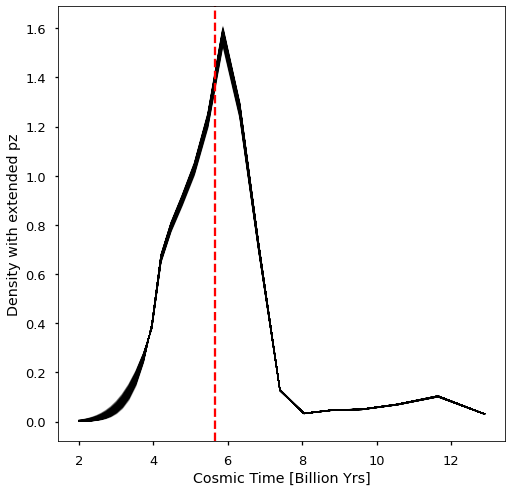

In [144]:
plt.figure(figsize=(8,8))
for ii in range(1000):
    plt.plot((13.6 - cosmo.lookback_time(zrange_comb).value), dndz_curves_extended[ii], 
             alpha = 0.1, c = 'k', lw = 1)
plt.axvline(13.6 - cosmo.lookback_time(1).value, ls = "--", c = 'r')
#plt.plot(tst_2[1][:-1] + np.diff(tst_2[1])/2, tst_2[0] * (1 - (test_specz == -99).sum()/len(test_specz)), alpha = 1, lw = 1, c = 'r', ls = '--')
plt.xlabel("Cosmic Time [Billion Yrs]")
plt.ylabel("Density with extended pz")
plt.show()

Check area under the curve

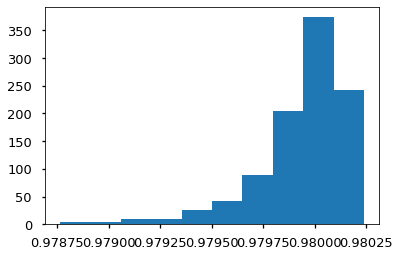

In [148]:
areas_all = np.trapz(dndz_curves_extended, zrange_comb, dx = 0.1)
plt.hist(areas_all, bins = 10);

In [104]:
zrange_extend = np.arange(zrange_hist[-1], 5, 0.1)
tail_curve_ii = tail_pz(normed_curve_ii[-1], r, zrange_extend, zrange_hist[-1])
np.trapz(tail_curve_ii, zrange_extend, dx = 0.1)

0.10313165319678917

In [100]:
pz_comb = np.concatenate((normed_curve_ii, tail_curve_ii))
zrange_comb = np.concatenate((zrange_hist, zrange_extend))

In [101]:
np.trapz(pz_comb, zrange_comb, dx = 0.1)

0.9781247784155741

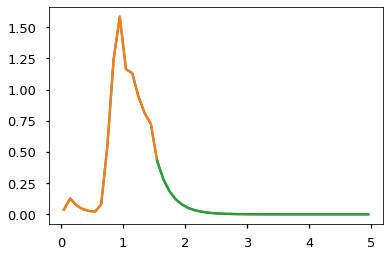

In [107]:
plt.plot(zrange_comb, pz_comb)
plt.plot(zrange_hist, normed_curve_ii)
plt.plot(zrange_extend, tail_curve_ii)